<a id='toc'></a>
# Список тестов по бригадам:

1. [Расчет процента подвязки между бригадами и локомотивами.](#perc_assign)
2. [Расчет процента запланированных бригад от общего количества бригад на входе планировщика.](#perc_assign2)
3. [Распределение между реальными и фейковыми бригадами в результатах планирования.](#real_fake)
4. [Составление списка станций и участков, на которых не состоялась подвязка бригады.](#no_assign)
5. [Проверка переработки бригад.](#overwork)   
6. [Проверка "скачков" бригад между станциями.](#leaps)
7. [Анализ времен стоянок поездов для смены бригады.](#stop_time)
8. [Анализ времен отдыха бригад.](#rest_time)
9. [Проверка корректности времен явки бригад во входных данных](#ready_time)
10. [Проверка смены бригад на корректных станциях](#change)
11. [Проверка отправления бригад до времени явки](#presence)
12. [Проверка планирования бригад до времени начала планирования](#before_current_time)
13. [Проверка планируемых явок бригад](#presenting)
14. [Проверка использования бригад после засылки пассажирами](#check_useful_assign)
  1. [Бригады, бесцельно отправляемые пассажирами](#only_pass)
  2. [Бригады, у которых запланирована только явка](#only_presence)
15. [Проверка подвязки негрузовых бригад](#pass_teams_in_plan)
16. [Проверка сохранения предыдущих времен явок](#Проверка-сохранения-предыдущих-времен-явок)
17. [Проверка возврата правильных времен явок у бригад](#Проверка-возврата-правильных-времен-явок-у-бригад)
18. [Проверка планирования УТХ бригад](#Проверка-планирования-УТХ-бригад)

### Константы и настройки

In [119]:
report = ''               # здесь будет храниться весь html-код отчета
FOLDER = 'resources/'     # папка с csv-файлами с данными
REPORT_FOLDER = 'report/' # папка для отчетов
PRINT = True              # выводить ли все таблицы из отчета на печать здесь в блокноте

In [120]:
TIME_FORMAT = '%b %d, %H:%M'
'''
    Преобразует время из timestamp в красивый формат, заданный в константе time_format
'''
def nice_time(t):
    return time.strftime(TIME_FORMAT, time.localtime(t)) if t > 0 else ''

def nice_print(s, **kwargs):    
    num = kwargs['num'] if 'num' in kwargs.keys() else False
    cols = kwargs['cols'] if 'cols' in kwargs.keys() else s.columns
    if num:
        print(s.reset_index()[cols].to_string())
    else:
        print(s[cols].to_string(index=False))

### Функции для экспорта в HTML

In [121]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="30%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [122]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv')
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                 'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Время составления отчета:', time.strftime(TIME_FORMAT, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (nice_time(current_time), current_time))

Время составления отчета: Aug 05, 19:03
Время запуска планировщика: Jul 13, 10:00 (1468393200)


In [123]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_f'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_f'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [124]:
add_line('Время сбора данных и запуска планировщика: %s' % nice_time(current_time))

Время сбора данных и запуска планировщика: Jul 13, 10:00


<a id='perc_assign'></a>
## Расчет процента подвязки между локомотивами и бригадами [ToC](#toc)

In [125]:
add_header('Расчет процента подвязки между локомотивами и бригадами', h=2, p=False)

In [126]:
def count_real_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             ((loco_plan.team == -1) | (loco_plan.team_type == 'Фейковая')) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без реальных бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    
    
def count_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             (loco_plan.team == -1) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    count_real_assign_percent(hor)   

    
if 'team' not in loco_plan.columns:
    loco_plan = loco_plan.set_index(['loco', 'time_start']).join(team_plan.loc[team_plan.state == 1, \
                                                                ['team', 'loco', 'time_start', 'team_type']].\
                                                                 set_index(['loco', 'time_start'])).reset_index()    
    loco_plan.team.fillna(-1, inplace=True)

count_assign_percent(6 * 3600)
count_assign_percent(12 * 3600)
count_assign_percent(24 * 3600)

Локомотивов без бригад на горизонте  6 часов: 36 из 1591 (процент подвязки 97%)
Локомотивов без реальных бригад на горизонте  6 часов: 104 из 1591 (процент подвязки 93%)
Локомотивов без бригад на горизонте 12 часов: 82 из 1591 (процент подвязки 94%)
Локомотивов без реальных бригад на горизонте 12 часов: 260 из 1591 (процент подвязки 83%)
Локомотивов без бригад на горизонте 24 часов: 161 из 1591 (процент подвязки 89%)
Локомотивов без реальных бригад на горизонте 24 часов: 426 из 1591 (процент подвязки 73%)


<a id='perc_assign2'></a>
## Расчет процента запланированных бригад от общего количества [ToC](#toc)

In [127]:
add_header('Расчет процента запланированных бригад от общего количества бригад на входе', h=2, p=False)

Всего бригад, запланированных с локомотивами в работе: 4080 из 5058 (80.66%)


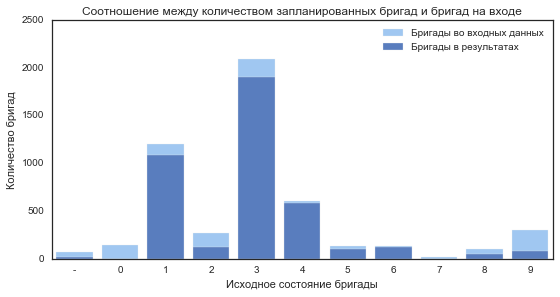

In [128]:
team_assigned_n = team_info[team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)]\
                    .drop_duplicates('team').team.count()
team_total_n = team_info.drop_duplicates('team').team.count()
team_assigned_percent = team_assigned_n / team_total_n
add_line('Всего бригад, запланированных с локомотивами в работе: %d из %d (%.2f%%)' %
      (team_assigned_n, team_total_n, 100 * team_assigned_percent))
team_info['is_assign'] = team_info.team.isin(team_plan[team_plan.state.isin([0, 1])].team)
assign_states = team_info.loc[team_info.is_assign == True, ['team', 'state']].state.astype(str).value_counts().to_frame()
initial_states = team_info.state.value_counts().to_frame()
initial_states.columns=['Бригады во входных данных']
assign_states.columns=['Бригады в результатах']
states = initial_states.join(assign_states)
states.fillna(0, inplace=True)

sns.set(style='white', context='notebook')
sns.set_color_codes('pastel')
fig = plt.figure(figsize=(8, 4))
sns.barplot(x='index', y='Бригады во входных данных', data=states.sort_index().reset_index(), 
            color="b", label='Бригады во входных данных')
sns.set_color_codes('muted')
ax = sns.barplot(x='index', y='Бригады в результатах', data=states.sort_index().reset_index(), 
            color="b", label='Бригады в результатах')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylabel='Количество бригад', xlabel='Исходное состояние бригады', 
       title='Соотношение между количеством запланированных бригад и бригад на входе')
#sns.despine()
filename = 'team_usage.png'
plt.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='real_fake'></a>
### Распределение реальных и фейковых бригад в результатах планирования

In [129]:
add_header('Распределение реальных и фейковых бригад в результатах планирования', h=2, p=False)

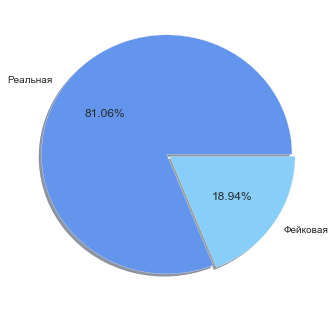

In [130]:
f = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').team_type.value_counts()
fig = plt.figure(figsize=(5,5))
colors = ['cornflowerblue', 'lightskyblue']
expl = (0.03, 0) if len(f) == 2 else None
plt.pie(f, autopct='%.2f%%', colors=colors, explode=expl, shadow=True, labels=list(f.index))
filename = 'real_fake_teams_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='no_assign'></a>
## Cтанции и участки, на которых не состоялась подвязка бригады [ToC](#toc)

In [131]:
add_header('Станции и участки, на которых не состоялась подвязка бригады', h=2, p=False)

In [132]:
horizon = 6 * 3600
add_line('Горизонт анализа: %d часов' % (horizon / 3600), p=False)
loco_mask = (loco_plan.time_start < current_time + horizon)

In [133]:
# Добавляем признак первой станции на маршруте локомотива, где не была подвязана бригада
loco_plan.loc[loco_plan.state == 4, 'team'] = 0
loco_plan['no_team_start'] = (loco_plan.team == -1) & \
                             ((loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1)))
    
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'team', 'no_team_start']
fail_team_assign_locos = loco_plan.loc[loco_mask & (loco_plan.no_team_start == True)]
fail_team_assign_stations = fail_team_assign_locos.st_from_name.value_counts().head(10)
fail_team_assign_tracks = fail_team_assign_locos.groupby('st_from_name').st_to_name.value_counts().\
                            sort_values(ascending=False).head(10)
add_header('Станции, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_stations)
add_header('\nУчастки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_tracks)

Станции, на которых не удалось подвязать бригады под локомотив (первые 10):
ИЛАНСКАЯ                9
КРАСНОЯРСК-ВОСТОЧНЫЙ    6
ВЫСОКОГОРНАЯ            4
ЛЕНА                    4
ЗАОЗЕРНАЯ               1
УСТЬ-ИЛИМСК             1
КОМСОМОЛЬСК-НА-АМУРЕ    1
КОРШУНИХА-АНГАРСКАЯ     1
МОГОЧА                  1
ВОЛОЧАЕВКА I            1

Участки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):
st_from_name          st_to_name 
ИЛАНСКАЯ              ЗАОЗЕРНАЯ      9
КРАСНОЯРСК-ВОСТОЧНЫЙ  ЗЫКОВО         6
ЛЕНА                  ХРЕБТОВАЯ      4
ВЫСОКОГОРНАЯ          СОЛЛУ          4
УЯР                   ЗЫКОВО         1
УСТЬ-ИЛИМСК           ДИАБАЗОВЫЙ     1
УССУРИЙСК             БАРАНОВСКИЙ    1
УРГАЛ I               ЧЕГДОМЫН       1
РУЖИНО                ШМАКОВКА       1
МОГОЧА                АМАЗАР         1


In [134]:
st_name = fail_team_assign_stations.head(1).index[0]
#st_name = 'КРАСНОЯРСК-ВОСТОЧНЫЙ'
bad_locos = loco_plan.loc[loco_mask & (loco_plan.st_from_name == st_name) & (loco_plan.no_team_start == True)]
if not bad_locos.empty:
    add_header('Локомотивы, к которым не была подвязана бригада на станции %s, по направлениям:' % st_name)
    add_line(bad_locos.st_to_name.value_counts())

Локомотивы, к которым не была подвязана бригада на станции ИЛАНСКАЯ, по направлениям:
ЗАОЗЕРНАЯ    9


<a id='overwork'></a>
## Проверка переработки бригад [ToC](#toc)

In [135]:
add_header('Бригады с переработкой', h=2, p=False)

#### Вычисляем последнее время явки для каждого участка на маршруте

In [136]:
# В поле presence прописываем последнюю явку бригады из входных данных
team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: max(x))
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['info_presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['info_presence_norm'] = team_plan.info_presence.apply(nice_time)
team_plan['info_presence'] = team_plan.info_presence.apply(lambda x: [] if np.isnan(x) else [int(x)])

# Собираем все запланированные явки бригады. 
# Если ни одной явки не запланировано, то проставляем фейковые явки: время первого отправления (после отдыха) минус 1 час
team_plan['start_trip'] = team_plan.state.isin([0, 1]) \
                & ((team_plan.team != team_plan.team.shift(1)) | (team_plan.state.shift(1) == 4))
team_plan['fake_plan_presence'] = team_plan.team.map(team_plan[team_plan.start_trip].groupby('team').time_start.unique() - 3600)
team_plan.fake_plan_presence.fillna(0, inplace=True)
team_plan['fake_plan_presence'] = team_plan.fake_plan_presence.apply(lambda x: [] if (type(x) == int) else x)
team_plan['plan_presence'] = team_plan.team.map(team_plan[team_plan.state == 2].groupby('team').time_start.unique())
team_plan.plan_presence.fillna(0, inplace=True)
team_plan['plan_presence'] = team_plan.plan_presence.apply(lambda x: [] if (type(x) == int) else x)

In [137]:
def get_curr_presence(row):
    real_presence = np.concatenate([row.info_presence, row.plan_presence])   
    if len(real_presence) > 0:
        presence_list = real_presence
    elif len(row.fake_plan_presence) > 0:
        presence_list = row.fake_plan_presence
    else:
        return current_time
        
    t = row.time_start
    b = [x for x in presence_list if x <= t]
    return int(max(b)) if b != [] else (row.fake_plan_presence[0] if len(row.fake_plan_presence) > 0 else current_time)   
    
    
team_plan['curr_presence'] = team_plan.apply(lambda row: get_curr_presence(row), axis=1)
#cols = ['team', 'st_from_name', 'time_start', 'state', 'info_presence', 'info_presence_norm', 
#        'plan_presence', 'fake_plan_presence', 'curr_presence']
#team_plan[team_plan.team == '777700001868'][cols]

#### Составляем таблицу team_trips с поездками бригад

In [138]:
cols = ['team', 'state', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'loco', 'start_trip', 'end_trip', 
        'start_trip_time', 'end_trip_time']
team_plan['end_trip'] = ((team_plan.team != team_plan.team.shift(-1)) & (team_plan.state == 1)) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(-1).isin([0, 2, 4])))
team_plan.loc[team_plan.end_trip == True, 'end_trip_time'] = team_plan.time_end
team_plan['start_trip'] = ((team_plan.state == 1) & (team_plan.team != team_plan.team.shift(1))) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(1).isin([0, 2, 4])))
team_plan.loc[team_plan.start_trip == True, 'start_trip_time'] = team_plan.time_start
start_trips = team_plan.dropna(subset=['start_trip_time'])
end_trips = team_plan.dropna(subset=['end_trip_time'])

frames = [start_trips.reset_index()[['team', 'state', 'st_from_name', 'start_trip_time']],
          end_trips.reset_index()[['st_to_name', 'end_trip_time', 'curr_presence']]]
team_trips = pd.concat(frames, axis=1, ignore_index=True)
team_trips.columns = ['team', 'state', 'st_from_name', 'time_start', 'st_to_name', 'time_end', 'curr_presence']
add_info(team_trips)
team_trips['curr_presence_norm'] = team_trips.curr_presence.apply(nice_time)

In [139]:
team_trips[team_trips.team == '777700001868']

,team,state,st_from_name,time_start,st_to_name,time_end,curr_presence,time_start_f,time_end_f,curr_presence_norm


#### Загружаем нормы рабочего времени и составляем таблицу по нормам для каждой бригады

In [140]:
WORK_TIME_LIMIT = 11 #hours

In [141]:
def get_cmp(row):
    d, l = row.depot, row.link    
    try:
        res = trd.ix[d].link.apply(lambda x: len(np.intersect1d(x, l))).idxmax()        
    except:
        res = -1
    return res

team_region = pd.read_csv(FOLDER + 'team_region.csv', dtype={'st_from':str, 'st_to':str, 'depot':str})
add_info(team_region)
team_region['link'] = list(zip(team_region.st_from, team_region.st_to))
team_plan['link'] = list(zip(team_plan.st_from, team_plan.st_to))
tr_links = team_region.groupby(['team_region', 'depot']).link.unique().to_frame().reset_index()
if not tr_links.empty:
    trd = tr_links.set_index(['depot', 'team_region'])
else:
    trd = tr_links
team_links = team_plan[team_plan.state.isin([0, 1])].groupby(['team', 'depot']).link.unique().to_frame().reset_index()
team_links['team_region'] = team_links.apply(lambda row: get_cmp(row), axis=1)

team_links['tr_depot'] = list(zip(team_links.team_region, team_links.depot))
team_region['tr_depot'] = list(zip(team_region.team_region, team_region.depot))
team_links['time_f'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_f)
team_links['time_b'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_b)
team_links['time_wr'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_wr)
#team_links.head()

In [142]:
time_limit = team_links[['team', 'time_f', 'time_b', 'time_wr']]
time_limit.head()

,team,time_f,time_b,time_wr
0,200200032986,NaN,NaN,NaN
1,200200033796,NaN,NaN,NaN
2,200200034977,NaN,NaN,NaN
3,200200036640,NaN,NaN,NaN
4,200200037385,NaN,NaN,NaN


#### Вычисляем переработки, предварительно удалив выбросы

In [143]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'curr_presence_norm']
outliers = team_trips[team_trips.curr_presence < current_time - 24 * 3600]
#outliers = team_trips[team_trips.info_presence < current_time - 24 * 3600]
outliers_n = outliers.team.count()
add_header('Всего %d бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:' % outliers_n)
add_line(outliers.sort_values('curr_presence_norm').head(10 if outliers_n > 20 else outliers_n)[cols])

Всего 0 бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:
Empty DataFrame
Columns: [team, st_from_name, st_to_name, time_start_f, time_end_f, curr_presence_norm]
Index: []


In [144]:
pd.set_option('display.max_colwidth', 25)
# Оставляем только корректные бригады
team_trips = team_trips[(team_trips.team.isin(outliers.team) == False) & (team_trips.time_start < current_time + 24 * 3600)]
team_trips['time_limit'] = team_trips.team.map(time_limit.set_index('team').time_f)
team_trips['time_limit_no_rest'] = team_trips.team.map(time_limit.set_index('team').time_wr)
team_trips.time_limit.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips.time_limit_no_rest.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips[['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'time_limit', 'time_limit_no_rest']].head()

,team,st_from_name,st_to_name,curr_presence_norm,time_start_f,time_end_f,time_limit,time_limit_no_rest
0,200200164066,УЯР,КРАСНОЯРСК-ВОСТОЧНЫЙ,"Jul 13, 06:23","Jul 13, 09:14","Jul 13, 11:10",39600,39600
2,200200225263,НОВЫЙ УРГАЛ,ТЫРМА,"Jul 13, 10:20","Jul 13, 12:20","Jul 13, 17:27",39600,39600
3,200200181294,УРУША,МАГДАГАЧИ,"Jul 13, 11:34","Jul 13, 12:25","Jul 13, 18:20",39600,39600
4,200200164078,ЗИМА,ИРКУТСК-СОРТИРОВОЧНЫЙ,"Jul 13, 12:59","Jul 13, 13:40","Jul 13, 17:50",39600,39600
5,200200164078,ИРКУТСК-СОРТИРОВОЧНЫЙ,ЗИМА,"Jul 13, 23:14","Jul 14, 01:08","Jul 14, 05:26",39600,39600


In [145]:
team_trips['work_time'] = np.round(((team_trips.time_end - team_trips.curr_presence) / 3600), 2)
#team_trips['overtime'] = team_trips.work_time.apply(lambda x: np.max([x - WORK_TIME_LIMIT, 0]))
team_trips['overtime'] = np.round((team_trips.time_end - team_trips.curr_presence - team_trips.time_limit) / 3600, 2)
team_trips['overtime'] = team_trips.overtime.apply(lambda x: 0 if x < 0 else x)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_end_f', 'overtime' ]
add_header('Количество бригад с переработкой (показаны первые 10 интервалов):')
add_line(pd.cut(team_trips.overtime, bins=np.arange(int(team_trips.overtime.max()) + 2), include_lowest=False)\
      .value_counts().head(10).sort_index())

Количество бригад с переработкой (показаны первые 10 интервалов):
(0, 1]      69
(1, 2]      58
(2, 3]      29
(3, 4]      30
(4, 5]      18
(5, 6]      16
(6, 7]       7
(8, 9]       7
(9, 10]      8
(11, 12]     6


In [146]:
pd.set_option('display.max_colwidth', 25)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'overtime' ]
add_header('\nБригады с переработкой больше 2 часов (всего %d):' % len(team_trips.loc[team_trips.overtime > 2].index))
add_line(team_trips.loc[team_trips.overtime > 2, cols].sort_values('overtime', ascending=False).head(20))

add_header('\nРаспределение бригад с переработкой больше 2 часов по типу:')
team_trips['team_type'] = team_trips.team.map(team_plan.drop_duplicates('team').set_index('team').team_type)
add_line(team_trips.loc[team_trips.overtime > 2].team_type.value_counts())


Бригады с переработкой больше 2 часов (всего 173):
         team st_from_name   st_to_name curr_presence_norm   time_start_f     time_end_f  overtime
 200200083240      ОБЛУЧЬЕ      ОБЛУЧЬЕ      Jul 13, 21:07  Jul 13, 21:47  Jul 18, 19:37    107.50
 777700000383    БЕЛОГОРСК    БЕЛОГОРСК      Jul 13, 19:53  Jul 13, 20:53  Jul 17, 09:58     75.09
 777700000479    МАГДАГАЧИ    МАГДАГАЧИ      Jul 13, 16:55  Jul 13, 17:55  Jul 16, 15:05     59.16
 200200102857    МАГДАГАЧИ  СКОВОРОДИНО      Jul 14, 01:16  Jul 14, 02:20  Jul 16, 18:05     53.83
 200200107099  КОШУРНИКОВО       АБАКАН      Jul 13, 18:24  Jul 13, 19:35  Jul 16, 08:41     51.27
 200200273289      ГОРЕЛЫЙ  СКОВОРОДИНО      Jul 13, 23:09  Jul 14, 00:09  Jul 16, 12:47     50.62
 200200234543       АБАКАН       АБАКАН      Jul 13, 20:30  Jul 13, 22:30  Jul 16, 09:03     49.57
 200200109431     КУРАГИНО       АБАКАН      Jul 13, 21:04  Jul 13, 22:04  Jul 16, 09:26     49.37
 200200087522       ЧИТА I       ЧИТА I      Jul 14, 03:3

In [147]:
team_ids = team_trips.loc[team_trips.overtime > 2].sort_values('overtime', ascending=False).team.values[:3]
#team_id = '777700001868'
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'time_end_f', 'loco']
team_info['depot_time_f'] = team_info.depot_time.apply(nice_time)
team_info['return_time_f'] = team_info.return_time.apply(nice_time)
team_info['depot_st_name'] = team_info.depot_st.map(st_names.name)
add_header('Примеры планов бригад с переработками:')
for team_id in team_ids:
    add_line('Бригада %s:' % team_id)
    add_line(team_info[team_info.team == team_id][['team', 'depot_st_name', 'depot_time_f', 'return_time_f', 'state', 'loco', 'loc_name']])
    add_line(team_plan[team_plan.team == team_id][cols])
    add_line('')

Примеры планов бригад с переработками:
Бригада 200200083240:
         team depot_st_name   depot_time_f return_time_f state          loco       loc_name
 200200083240       ОБЛУЧЬЕ  Jul 13, 01:11                   6  200200107079  ВОЛОЧАЕВКА II
         team   st_from_name     st_to_name  state   time_start_f     time_end_f          loco
 200200083240  ВОЛОЧАЕВКА II  ВОЛОЧАЕВКА II      4  Jul 13, 10:44  Jul 13, 15:14            -1
 200200083240  ВОЛОЧАЕВКА II     ТУНГУССКИЙ      0  Jul 13, 15:14  Jul 13, 15:27            -1
 200200083240     ТУНГУССКИЙ   ВОЛОЧАЕВКА I      0  Jul 13, 15:27  Jul 13, 15:34            -1
 200200083240   ВОЛОЧАЕВКА I            NaN      0  Jul 13, 15:34  Jul 13, 17:23            -1
 200200083240            NaN           БИРА      0  Jul 13, 17:23  Jul 13, 18:13            -1
 200200083240           БИРА    ИЗВЕСТКОВАЯ      0  Jul 13, 18:13  Jul 13, 19:35            -1
 200200083240    ИЗВЕСТКОВАЯ        ОБЛУЧЬЕ      0  Jul 13, 19:35  Jul 13, 20:26          

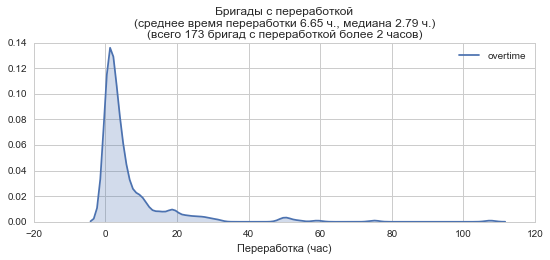

In [148]:
fig = plt.figure(figsize=(8, 3))
sns.set(style='whitegrid', context='notebook')
to_hist = team_trips.loc[team_trips.overtime > 0].overtime
sns.kdeplot(to_hist, shade=True)
title = '''Бригады с переработкой
(среднее время переработки %.2f ч., медиана %.2f ч.)
(всего %d бригад с переработкой более 2 часов)''' % \
            (to_hist.mean(), to_hist.median(), len(team_trips.loc[team_trips.overtime > 2].index))
plt.title(title)
plt.xlabel('Переработка (час)')
filename = 'team_overwork.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='leaps'></a>
## Скачки по станциям на маршруте бригад [ToC](#toc)

In [149]:
add_header('Скачки по станциям на маршруте бригад', h=2, p=False)

### Скачки внутри планируемого маршрута бригад

In [150]:
pd.set_option('display.max_colwidth', 20)
team_cols = ['team', 'st_from_name', 'st_to_name', 'next_st', 'time_start_f', 'time_end_f', 'state', 'state_info']
team_plan['is_end'] = team_plan.team != team_plan.team.shift(-1)
team_plan['next_st'] = team_plan.st_from_name.shift(-1)
team_leaps = team_plan.loc[(team_plan.is_end == False) 
                           & (team_plan.st_to_name != team_plan.next_st)
                           & (team_plan.st_to_name.notnull())
                           & (team_plan.next_st.notnull()), team_cols]
team_leaps_n = len(team_leaps.team.drop_duplicates().index)
add_header('\nВсего бригад, у которых есть скачки на маршруте: %d' % team_leaps_n)
add_header('Всего скачков на маршруте бригад: %d (показаны первые 10):' % len(team_leaps.index))
add_line(team_leaps.head(20))

add_header('\nСтанции, на которых наблюдаются скачки (первые 5):')
add_line(team_leaps.st_to_name.value_counts().head())

# Пример маршрута такой бригады (подставить id из предыдущего вывода):
team_cols2 = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'state_info']
#team_id = '200200164017'
if not team_leaps.empty:
    team_id = team_leaps.iloc[0].team
    add_header('\nМаршрут бригады %s:' % team_id)
    add_line(team_plan.loc[team_plan.team == team_id, team_cols2])


Всего бригад, у которых есть скачки на маршруте: 153
Всего скачков на маршруте бригад: 175 (показаны первые 10):
         team         st_from_name           st_to_name              next_st   time_start_f     time_end_f  state state_info
 200200199025            БЕЛОГОРСК            БЕЛОГОРСК         БЕЛОГОРСК II  Jul 14, 14:13  Jul 14, 15:31      2          3
 200200127736            БЕЛОГОРСК            БЕЛОГОРСК         БЕЛОГОРСК II  Jul 15, 09:06  Jul 15, 10:24      2          3
 200200233912                БОРЗЯ                БОРЗЯ           ШАХТЕРСКАЯ  Jul 13, 14:05  Jul 13, 14:25      2          2
 200200136435             УЛАН-УДЭ             УЛАН-УДЭ               ТАЛЬЦЫ  Jul 14, 02:27  Jul 14, 03:13      2          1
 200200242608                ХИЛОК                ХИЛОК             ЖИПХЕГЕН  Jul 13, 14:51  Jul 13, 16:00      2          4
 200200216349            БЕЛОГОРСК            БЕЛОГОРСК         БЕЛОГОРСК II  Jul 18, 00:53  Jul 18, 02:11      2          3
 2002002239

### Скачки между станцией исходного местоположения и первой станцией планирования

In [151]:
team_info.loc[team_info.st_from != '-1', 'first_station'] = team_info.loc[team_info.st_from != '-1', 'st_from']
team_info.loc[team_info.st_from == '-1', 'first_station'] = team_info.loc[team_info.st_from == '-1', 'oper_location']
team_info.loc[team_info.st_to != '-1', 'next_station'] = team_info.loc[team_info.st_to != '-1', 'st_to']
team_info[['team', 'oper_location', 'st_from', 'first_station', 'next_station']]
team_plan['first_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').first_station)
team_plan['next_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').next_station)
team_plan['first_st_name'] = team_plan.first_station.map(st_names.name)
team_plan['next_st_name'] = team_plan.next_station.map(st_names.name)
team_starts = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').copy(deep=True)
start_leaps = team_starts[((team_starts.first_station.isnull() == False) & (team_starts.st_from != team_starts.first_station)) | 
            ((team_starts.next_station.isnull() == False) & (team_starts.st_to != team_starts.next_station))]

In [152]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info']
first_st_leaps = team_starts[(team_starts.first_station.isnull() == False) & (team_starts.next_station.isnull())
                             & (team_starts.st_from != team_starts.first_station)]
add_header('Распределение скачков бригад по станциям местоположения (показаны первые 5):')
add_line(first_st_leaps.first_st_name.value_counts().head())
add_header('\nБригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):')
add_line(first_st_leaps[cols].head(10))

Распределение скачков бригад по станциям местоположения (показаны первые 5):
БЕЛОГОРСК                73
БЕЛОГОРСК II             10
ИРКУТСК-СОРТИРОВОЧНЫЙ     9
ВИХОРЕВКА                 5
КРАСНОЯРСК-ВОСТОЧНЫЙ      5

Бригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):
         team         st_from_name           st_to_name          loco        first_st_name next_st_name loco_info
 200200199025         БЕЛОГОРСК II            БЕЛОГОРСК  200200057242            БЕЛОГОРСК          NaN        -1
 200200233912           ШАХТЕРСКАЯ  ЯСНОГОРСК-ЗАБАЙК...  200200061157                БОРЗЯ          NaN        -1
 200200242608             ЖИПХЕГЕН                ХИЛОК  200200089571                ХИЛОК          NaN        -1
 200200216349         БЕЛОГОРСК II              ЗАВИТАЯ  200200092610            БЕЛОГОРСК          NaN        -1
 200200223941            БАГУЛЬНАЯ             МОРГУДОН  200200139309            ВИХОРЕВКА          NaN        

In [153]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info', 'train']
loco_info['train_number'] = loco_info.train.map(train_info.drop_duplicates('train').set_index('train').number)
team_starts['train'] = team_starts.loco_info.map(loco_info.drop_duplicates('loco').set_index('loco').train_number)
next_st_leaps = team_starts[(team_starts.next_station.isnull() == False) 
                            & (team_starts.st_to != team_starts.next_station)]
add_header('Распределение скачков бригад по станциям направления (показаны первые 5):')
add_line(next_st_leaps.next_st_name.value_counts())
add_header('\nБригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):')
add_line(next_st_leaps[cols].head(10))

Распределение скачков бригад по станциям направления (показаны первые 5):
БЕРКАКИТ           4
СЕЛЬГОН            3
ЗЫКОВО             2
ЛОПЧА              2
СИБИРЦЕВО          2
НАЗАРОВО           1
БИРА               1
ХАБЗАС             1
ЗАГУСТАЙ           1
АНИСИМОВКА         1
БОЛЬШОЙ ЛУГ        1
КИЖА               1
ЗЛОБИНО            1
ХАБАРОВСК I        1
ПОСТ-ПОКРОВСКИЙ    1
РОЗЕНГАРТОВКА      1
УРГАЛ I            1
ЛЕСНАЯ             1
СОЛОНИ             1
СЛЮДЯНКА II        1
УЛУЙ               1
ТОРЕЯ              1

Бригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):
         team st_from_name           st_to_name          loco        first_st_name next_st_name     loco_info  train
 200200136231   АНИСИМОВКА           НОВОНЕЖИНО            -1      КРАСНОАРМЕЙСКИЙ   АНИСИМОВКА  200200103257   4003
 200200243062         УЛУЙ          ПРИГОРОДНЫЙ  200200093935             НАЗАРОВО         УЛУЙ  200200082668   4890
 2

<a id='stop_time'></a>
## Анализ времен стоянок локомотивов для смены бригады [ToC](#toc)

In [154]:
add_header('Анализ времен стоянок локомотивов для смены бригады', h=2, p=False)

#### Распределение времен стоянок для смены бригады

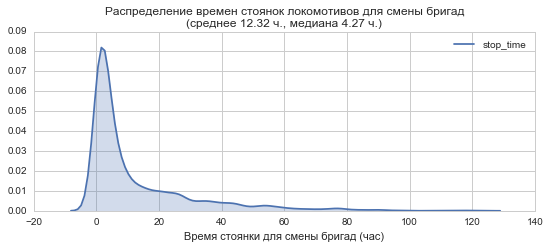

In [155]:
# Смена бригады без стоянки локомотива
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team', 'time_start_next', 'loco_finish', 'stop_time']

loco_plan['team_start'] = (loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1))
loco_plan['team_end'] = (loco_plan.team != loco_plan.team.shift(-1)) | (loco_plan.loco != loco_plan.loco.shift(-1))
start_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_start == True)].reset_index()\
                            [['loco', 'st_from_name', 'time_start', 'time_start_f', 'train', 'team']]
end_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_end == True)].reset_index()\
                            [['st_to_name', 'time_end', 'time_end_f']]
teams_trip = pd.concat([start_teams, end_teams], axis=1)
teams_trip['time_start_next'] = teams_trip.time_start.shift(-1)
teams_trip['loco_finish'] = teams_trip.loco != teams_trip.loco.shift(-1)
teams_trip.loc[teams_trip.loco_finish == False, 'stop_time'] = teams_trip.time_start_next - teams_trip.time_end
sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 3))
series_to_hist = teams_trip.dropna(subset=['stop_time']).stop_time / 3600
title = 'Распределение времен стоянок локомотивов для смены бригад\n(среднее %.2f ч., медиана %.2f ч.)' %\
        (series_to_hist.mean(), series_to_hist.median())
sns.kdeplot(series_to_hist, shade=True)
plt.title(title)
plt.xlabel('Время стоянки для смены бригад (час)')
filename = 'loco_stop_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Поиск локомотивов, у которых смены бригады занимает меньше 15 минут

In [156]:
#add_line('Время начала планирования' % time.ctime(current_time))
cols2 = ['loco', 'st_from_name', 'st_to_name', 'time_end_f', 'tsn_norm', 'train', 'stop_time', 'team']
pd.set_option('display.max_colwidth', 20)
teams_trip = teams_trip.dropna(subset=['time_start_next'])
teams_trip['tsn_norm'] = teams_trip.time_start_next.apply(nice_time)
teams_trip.loc[teams_trip.stop_time.isnull() == False, 'next_team'] = teams_trip.team.shift(-1)
teams_trip['train_type'] = teams_trip.train.apply(lambda x: 'Резерв' if str(x)[0]=='8' \
                                                      else ('Задания' if str(x)[0]=='9' else 'Реальный'))
fast_change = teams_trip.loc[teams_trip.stop_time < 15 * 60]
if fast_change.empty == False:
    add_header('Всего %d локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):' % len(fast_change.index))
    add_line(fast_change[cols2].sort_values(['stop_time', 'loco']).head(10))
    add_header('\nРаспределение проблемных локомотивов по станциям смены (показаны первые 10 по частоте):')
    bad_st = fast_change.st_to_name.value_counts().to_frame().reset_index()
    bad_st.columns = ['station', 'freq']
    bad_st['norm_time'] = bad_st['station'].map(stations.drop_duplicates(subset=['name']).set_index('name').norm_time)
    add_line(bad_st.head(10))
    add_header('\nРаспределение проблемных локомотивов по типам поездов:')    
    add_line(fast_change.train_type.value_counts())
else:
    add_line('Нет локомотивов со сменой бригад со стоянкой меньше 15 минут')
    
# Посмотреть маршруты конкретных локомотивов или бригад
loco_cols = ['loco', 'st_from','st_to', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team']
#team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
#print(loco_plan.loc[loco_plan.loco == '200200093307', loco_cols].to_string(index=False))
#print(team_plan.loc[team_plan.loco == '200250042559', team_cols].sort_values('time_start_norm').to_string(index=False))

Всего 169 локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):
         loco         st_from_name           st_to_name     time_end_f       tsn_norm            train  stop_time          team
 200214358614         ВОЛОЧАЕВКА I                  NaN  Jul 14, 14:40  Jul 14, 13:24   88880016814843      -4527  200200250427
 200200050978           ПАРТИЗАНСК              ЛОЗОВЫЙ  Jul 13, 17:09  Jul 13, 16:56     200230945360       -748  200200271880
 200200106334               АБАКАН             ПОДСИНИЙ  Jul 14, 01:42  Jul 14, 01:33  999928883032000       -515  200218472402
 200200088027         МЕЖДУРЕЧЕНСК               АБАКАН  Jul 14, 10:43  Jul 14, 10:38   88880014594676       -337  200200248177
 200200050978        МЫС АСТАФЬЕВА              ЛОЗОВЫЙ  Jul 13, 16:56  Jul 13, 16:55   88880002704373       -100  777700000083
 200200080455                КИТОЙ                МЕГЕТ  Jul 15, 07:52  Jul 15, 07:51   88880006974474        -83  777700000990
 200200080455           БА

<a id='rest_time'></a>
## Проверка времен отдыха бригад [ToC](#toc)

In [157]:
add_header('Проверка времен отдыха бригад', h=2, p=False)

In [158]:
add_line('Время начала планирования: %s' % nice_time(current_time))
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state', 'loco']
team_plan['time'] = np.round(((team_plan.time_end - team_plan.time_start) / 3600), 2)
rest_outliers = team_plan[(team_plan.state == 4) & (team_plan.time > 1000)]
add_header('Бригад с аномально большим временем отдыха: %d (показаны первые 10):' % len(rest_outliers.index))
out_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state']
if not rest_outliers.empty:
    add_line(rest_outliers[out_cols].head(10))

rest_check = team_plan[(team_plan.state == 4) & (team_plan.time < 1000)]

min_rest = rest_check.time.min()
if min_rest < 3:
    add_header('Минимальное время отдыха (3 часа) нарушено у %d бригад (показаны первые 10):' \
          % len(rest_check[rest_check.time < 3].index))
    add_line(rest_check[rest_check.time < 3][out_cols].head(10))    
else:
    add_header('Минимальное время отдыха бригад: %.2f часа' % (min_rest))

Время начала планирования: Jul 13, 10:00
Бригад с аномально большим временем отдыха: 0 (показаны первые 10):
Минимальное время отдыха (3 часа) нарушено у 3 бригад (показаны первые 10):
         team st_from_name st_to_name   time_start_f     time_end_f  time  state
 200200251301     МАРИИНСК   МАРИИНСК  Jul 13, 10:06  Jul 13, 10:00 -0.10      4
 200200138591     МАРИИНСК   МАРИИНСК  Jul 13, 10:40  Jul 13, 10:00 -0.67      4
 200200185588     МАРИИНСК   МАРИИНСК  Jul 13, 09:14  Jul 13, 10:00  0.77      4


#### Отсев бригад со слишком ранним временем явки

In [159]:
rest_old_presence = rest_check[(rest_check.info_presence < current_time - 12 * 3600) & (rest_check.state_info != '3')]
add_header('Всего %d бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:' 
           % rest_old_presence.team.count())
add_line(rest_old_presence.sort_values('time', ascending=False)[out_cols].head(10))

Всего 430 бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:
         team         st_from_name           st_to_name   time_start_f     time_end_f   time  state
 200200238558            ОЛОВЯННАЯ            ОЛОВЯННАЯ  Jul 12, 16:31  Jul 13, 19:31  27.00      4
 200200255347                 ЛЕНА                 ЛЕНА  Jul 13, 00:10  Jul 14, 03:03  26.89      4
 200200198334  КОРШУНИХА-АНГАРСКАЯ  КОРШУНИХА-АНГАРСКАЯ  Jul 13, 06:50  Jul 14, 06:28  23.64      4
 200200267850  КОРШУНИХА-АНГАРСКАЯ  КОРШУНИХА-АНГАРСКАЯ  Jul 13, 08:35  Jul 14, 06:28  21.89      4
 200200250082                ХИЛОК                ХИЛОК  Jul 12, 14:33  Jul 13, 12:25  21.87      4
 200200135584            ОЛОВЯННАЯ            ОЛОВЯННАЯ  Jul 12, 14:30  Jul 13, 12:04  21.57      4
 200200247439             АЧИНСК I             АЧИНСК I  Jul 12, 16:10  Jul 13, 13:40  21.50      4
 200200234406                ХИЛОК                ХИЛОК  Jul 13, 06:10  Jul 14, 03:38  21.48 

#### Бригады со слишком большим отдыхом

In [160]:
long_rest = rest_check[(rest_check.time > 10) & (rest_check.team.isin(rest_old_presence.team) == False)]
add_header('Всего %d бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):' % len(long_rest.index))
add_line(long_rest.sort_values('time', ascending=False)[out_cols].head(10))

Всего 191 бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):
         team st_from_name   st_to_name   time_start_f     time_end_f   time  state
 200200157452  СКОВОРОДИНО  СКОВОРОДИНО  Jul 13, 22:37  Jul 16, 02:43  52.11      4
 200200287901  СКОВОРОДИНО  СКОВОРОДИНО  Jul 14, 05:58  Jul 16, 02:43  44.75      4
 200200261410  СКОВОРОДИНО  СКОВОРОДИНО  Jul 14, 05:58  Jul 16, 02:43  44.75      4
 200200229445  СКОВОРОДИНО  СКОВОРОДИНО  Jul 14, 05:58  Jul 16, 02:43  44.75      4
 200200216354      ГОРЕЛЫЙ      ГОРЕЛЫЙ  Jul 13, 17:29  Jul 15, 11:07  41.64      4
 200200231087      ГОРЕЛЫЙ      ГОРЕЛЫЙ  Jul 13, 19:45  Jul 15, 11:07  39.36      4
 777700001063  СКОВОРОДИНО  СКОВОРОДИНО  Jul 14, 14:42  Jul 16, 02:43  36.02      4
 200200278214        ШТУРМ        ШТУРМ  Jul 14, 00:33  Jul 15, 12:26  35.88      4
 200200092236      ГОРЕЛЫЙ      ГОРЕЛЫЙ  Jul 14, 00:30  Jul 15, 11:07  34.61      4
 777700000009    КАРЫМСКАЯ    КАРЫМСКАЯ  Jul 13, 17:51  Jul 14, 22:26  28.57 

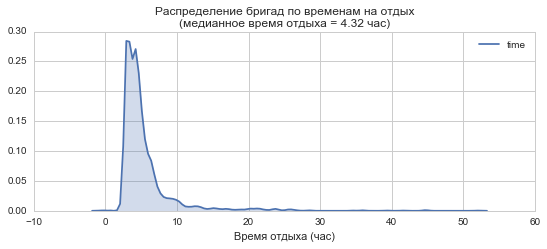

In [161]:
rest_show = rest_check[(rest_check.team.isin(rest_old_presence.team) == False)]
fig = plt.figure(figsize=(8, 3))
title = 'Распределение бригад по временам на отдых\n(медианное время отдыха = %.2f час)' % (rest_show.time.median())
sns.kdeplot(rest_show.time, shade=True)
plt.title(title)
plt.xlabel('Время отдыха (час)')
filename = 'team_rest_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Бригады с недостаточным отдыхом

In [162]:
rest = team_plan[team_plan.state == 4][['team', 'time_start', 'time']]
team_trips['rest_start_time'] = team_trips.team.map(rest.set_index('team').time_start)
team_trips['rest_start_time_f'] = team_trips.rest_start_time.apply(nice_time)
team_trips['rest_time'] = team_trips.team.map(rest.set_index('team').time)
team_trips['min_rest_time'] = np.round((team_trips.rest_start_time - team_trips.curr_presence) / (2 * 3600), 2)
team_trips['underrest'] = team_trips.min_rest_time - team_trips.rest_time

In [163]:
# Для подсчета требуемого отдыха удаляем поездки, которые связаны с одной явкой бригады; 
# для каждой явки оставляем только последнюю поездку, чтобы правильно взять полное рабочее время.
team_trips_cut = team_trips.sort_values(['team', 'curr_presence', 'work_time'], ascending=[True, True, False])\
                            .drop_duplicates(subset=['team', 'curr_presence'])

In [164]:
cols = ['team', 'curr_presence_norm', 'time_start_f', 'rest_start_time_f', 
        'work_time', 'min_rest_time', 'rest_time', 'underrest']
underrest = team_trips_cut[(team_trips_cut.time_start < team_trips_cut.rest_start_time) & (team_trips_cut.underrest > 0)]
underrest_n = underrest.team.drop_duplicates().count()
add_header('Всего %d бригад с недостаточным отдыхом:' % underrest_n)
add_header('Распределение по типу бригад:')
add_line(underrest.team_type.value_counts())

Всего 638 бригад с недостаточным отдыхом:
Распределение по типу бригад:
Реальная    551
Фейковая     87


Всего 571 бригад без переработки с недостаточным отдыхом.

Распределение по типу бригад:
Реальная    487
Фейковая     84

Примеры бригад без переработки с недостаточным отдыхом:
         team curr_presence_norm   time_start_f rest_start_time_f  work_time  min_rest_time  rest_time  underrest
 200200200050      Jul 14, 02:23  Jul 14, 03:28     Jul 14, 12:39       6.66           5.13       3.00       2.13
 200200145166      Jul 14, 03:02  Jul 14, 03:43     Jul 14, 13:10       5.05           5.06       3.00       2.06
 200200136100      Jul 13, 14:50  Jul 13, 15:55     Jul 14, 04:12       6.54           6.68       4.85       1.83
 200200205606      Jul 13, 23:23  Jul 14, 00:28     Jul 14, 09:02       6.50           4.82       3.00       1.82
 200200247759      Jul 13, 10:20  Jul 13, 11:25     Jul 13, 22:50       6.54           6.24       4.47       1.77
 200200214580      Jul 13, 13:49  Jul 13, 14:30     Jul 13, 23:18       4.88           4.74       3.00       1.74
 200200216057      Jul 1

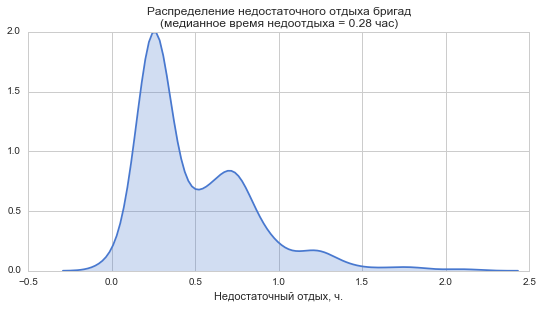

In [165]:
underrest_no_overtime = underrest[underrest.work_time <= WORK_TIME_LIMIT]
underrest_no_n = underrest_no_overtime.team.drop_duplicates().count()
add_header('Всего %d бригад без переработки с недостаточным отдыхом.' % underrest_no_n)
add_header('\nРаспределение по типу бригад:')
add_line(underrest_no_overtime.team_type.value_counts())
add_header('\nПримеры бригад без переработки с недостаточным отдыхом:')
add_line(underrest_no_overtime.sort_values('underrest', ascending=False)\
         .head(10 if underrest_no_n > 20 else underrest_no_n)[cols])

sns.set(style='whitegrid', context='notebook')
title = 'Распределение недостаточного отдыха бригад\n(медианное время недоотдыха = %.2f час)' \
            % (underrest_no_overtime.underrest.median())
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(underrest_no_overtime.underrest, color='b', hist=False, kde_kws={'shade':True})
ax.set(title=title, xlabel='Недостаточный отдых, ч.')
filename = 'team_under_rest.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [166]:
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['train'] = team_plan.loco_time.map(loco_plan.drop_duplicates('loco_time').set_index('loco_time').train)
#print(team_plan[team_plan.team == '777700000270']\
#      [['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 
#        'state', 'loco', 'train', 'time']].to_string(index=False))
time.ctime(1463065200)

'Thu May 12 18:00:00 2016'

## Проверка подвязки бригад по Иркутску

In [167]:
add_header('Анализ бригад, проезжающих через Иркутск', h=2, p=False)

In [168]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'depot_name']
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
train_cols = ['train', 'number', 'st_from_name', 'st_to_name', 'time_start_f']
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
add_header('Распределение поездов через Иркутск по направлениям:')
add_line(train_plan.loc[(train_plan.st_from_name == st_name)
              & (train_plan.time_start >= current_time) & (train_plan.train_type.isin(['2', '9']))
              & (train_plan.time_start < current_time + 24*3600), train_cols].st_to_name.value_counts())

add_header('\nРаспределение бригад, в маршруте которых есть Иркутск, по депо приписки:')
b = team_plan.loc[(team_plan.st_from_name == st_name) & (team_plan.state.isin([0, 1]))
              & (team_plan.time_start >= current_time), team_cols].groupby('depot_name').team.count().to_frame()
b['percent'] = np.round((100 * b.team / b.team.sum()), 2)
b['percent'] = b['percent'].apply(lambda x: str(x) + '%')
add_line(b.reset_index())

Распределение поездов через Иркутск по направлениям:
ГОНЧАРОВО     65
БАТАРЕЙНАЯ    28

Распределение бригад, в маршруте которых есть Иркутск, по депо приписки:
          depot_name  team percent
                ЗИМА   118  54.38%
 ИРКУТСК-СОРТИРОВ...    91  41.94%
         НИЖНЕУДИНСК     1   0.46%
          СЛЮДЯНКА I     4   1.84%
            УЛАН-УДЭ     3   1.38%


<a id='ready_time'></a>
## Проверка времени явки бригад [ToC](#toc)

In [169]:
add_header('Проверка корректости времен явки бригад в депо приписки во входных данных', h=2, p=False)

1. У бригад, которые находятся на домашнем отдыхе (state = 3) передается именно время ухода на отдых. По постановке (см. раздел "Заполнение атрибутов для входных сообщений по бригадам") должно передаваться время ухода на отдых + 16 часов.
2. Для бригады 200200158216 передается state=3, хотя по АСУ-Т последней операцией на 18.04 10:35 было "прибытие на станцию Лесовозный 17.04 в 08:49" (или, в крайнем случае, отправление с Улан-Удэ 17.04 в 07:51).
3. Аналогично для бригады 200200225600. Впрочем, возможно, это какой-то косяк АСУ-Т. В любом случае, пункт 1 - это очевидный баг.

Общая идея:
- если у бригад указано depot_time < rest_start_time, то эта разница не должна быть очень большой. 
- если у бригад указано depot_time < return_time, то эта разница тоже не должна быть очень большой.

In [170]:
add_line('Время начала планирования: %s' % (nice_time(current_time)))
team_info['dt_norm'] = team_info.depot_time.apply(nice_time)
team_info['rt_norm'] = team_info.return_time.apply(nice_time)
team_info['rst_norm'] = team_info.rest_time.apply(nice_time)
team_info['rest_dep_delta'] = np.round(((team_info.rest_time - team_info.depot_time) / 3600), 2)
team_info['return_dep_delta'] = np.round(((team_info.return_time - team_info.depot_time) / 3600), 2)

dep_less_rest = team_info[(team_info.depot_time < team_info.rest_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'rest_dep_delta', 'ready_type', 'state']
add_header('Всего %d бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:' 
          % dep_less_rest[dep_less_rest.rest_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_rest[dep_less_rest.rest_dep_delta > 12][info_cols].sort_values('rest_dep_delta', ascending=False).head(10))

dep_less_return = team_info[(team_info.depot_time < team_info.return_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'return_dep_delta', 'ready_type', 'state']
add_header('\nВсего %d бригад, у которых время последней явки в депо намного меньше (на 18+ часов) времени явки в пункте оборота. Примеры:' 
          % dep_less_return[dep_less_return.return_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_return[dep_less_return.return_dep_delta > 12][info_cols].sort_values('return_dep_delta', ascending=False).head(10))

Время начала планирования: Jul 13, 10:00
Всего 314 бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:
         team      number dt_norm       rst_norm  rest_dep_delta ready_type state
 200200184068  9609082423          Jul 13, 08:20       407885.33     return     4
 200200253612  9604004298          Jul 13, 07:04       407884.07     return     4
 200200223494  8801002188          Jul 13, 04:51       407881.85     return     4
 200200143073  8802003560          Jul 13, 02:40       407879.67     return     4
 200200195663  8802001166          Jul 13, 02:40       407879.67     return     4
 200200104780  9405053254          Jul 12, 19:30       407872.50     return     6
 200200210169  8877004947          Jul 12, 17:50       407870.83     return     1
 200200234719  9403005414          Jul 12, 16:00       407869.00     return     4
 200200110664  9406024390          Jul 12, 14:17       407867.28     return     9
 20020016

<a id='change'></a>
## Проверка смены бригад на корректных станциях [ToC](#toc)

In [171]:
add_header('Проверка смены бригад на корректных станциях', h=2, p=False)

### Проверка случаев проезда бригад мимо станций обязательной смены

In [172]:
add_header('Проверка проезда бригад мимо станций обязательной смены', h=3, p=False)

In [173]:
st_team_change_full = ['КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗИМА', 'ХИЛОК', 'МОГОЧА', 'ОБЛУЧЬЕ', 'РУЖИНО', 'СМОЛЯНИНОВО', 
                      'САЯНСКАЯ', 'ЛЕНА', 'СЕВЕРОБАЙКАЛЬСК', 'НОВЫЙ УОЯН', 
                      'НОВАЯ ЧАРА', 'ЮКТАЛИ', 'ВЕРХНЕЗЕЙСК', 'ФЕВРАЛЬСК', 'ПОСТЫШЕВО', 'ВЫСОКОГОРНАЯ', 
                      'УЖУР', 'ТЫРМА']
                 
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'loco_end', 'no_stop']
team_plan['loco_end'] = team_plan.loco != team_plan.loco.shift(-1)
team_plan['no_stop'] = team_plan.time_end == team_plan.time_start.shift(-1)
no_stop = team_plan[(team_plan.st_to_name.isin(st_team_change_full)) & (team_plan.state == 1) 
                    & (team_plan.loco_end == False) & (team_plan.no_stop == True)]
add_header('Всего %d случаев проезда бригад мимо станций обязательной смены' % len(no_stop.index))
add_header('\nРаспределение по станциям (первые 5 самых частых):')
add_line(no_stop.st_to_name.value_counts().head())

Всего 55 случаев проезда бригад мимо станций обязательной смены

Распределение по станциям (первые 5 самых частых):
РУЖИНО        20
САЯНСКАЯ       9
НОВЫЙ УОЯН     6
ХИЛОК          6
ЗИМА           4


In [174]:
add_header('\nПримеры ошибочных бригад (первые 10):')
add_line(no_stop.drop_duplicates('st_to_name').sort_values('time_end')[cols])


Примеры ошибочных бригад (первые 10):
         team      st_from_name    st_to_name   time_start_f     time_end_f  state          loco loco_end no_stop
 200200095938             СОЛЛУ  ВЫСОКОГОРНАЯ  Jul 13, 11:14  Jul 13, 11:26      1  200200076718    False    True
 200200174199        НОВОНЕЖИНО   СМОЛЯНИНОВО  Jul 13, 11:23  Jul 13, 11:48      1  200214358614    False    True
 200200250427            АРХАРА       ОБЛУЧЬЕ  Jul 13, 10:35  Jul 13, 12:42      1  200200091512    False    True
 200200189851          ЖИПХЕГЕН         ХИЛОК  Jul 13, 13:53  Jul 13, 14:24      1  200200083188    False    True
 200200140523          ТАЛАНДЖА         ТЫРМА  Jul 13, 21:40  Jul 13, 23:26      1  200200107108    False    True
 200200215093             ЛОПЧА        ЮКТАЛИ  Jul 13, 21:39  Jul 14, 01:46      1  200200103671    False    True
 200200252808             ТИСИН          УЖУР  Jul 14, 02:30  Jul 14, 04:45      1  200200097344    False    True
 200200274674         АНГАРАКАН    НОВЫЙ УОЯН  Ju

In [175]:
add_header('Полные планы по некоторым ошибочным бригадам:')
top_st = no_stop.st_to_name.value_counts().index[0]
sec_st = no_stop.st_to_name.value_counts().index[1]
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
add_line(team_plan[team_plan.team == no_stop[no_stop.st_to_name == top_st].iloc[0].team][cols])
add_line('')
add_line(team_plan[team_plan.team == no_stop[no_stop.st_to_name == sec_st].iloc[0].team][cols])

Полные планы по некоторым ошибочным бригадам:
         team      st_from_name        st_to_name   time_start_f     time_end_f  state          loco
 200200097619      ХАБАРОВСК II      ХАБАРОВСК II  Jul 13, 21:09  Jul 13, 22:15      2            -1
 200200097619      ХАБАРОВСК II        КРУГЛИКОВО  Jul 13, 22:15  Jul 13, 22:55      1  200200091326
 200200097619        КРУГЛИКОВО         ВЯЗЕМСКАЯ  Jul 13, 22:55  Jul 14, 00:23      1  200200091326
 200200097619         ВЯЗЕМСКАЯ     РОЗЕНГАРТОВКА  Jul 14, 00:23  Jul 14, 01:32      1  200200091326
 200200097619     РОЗЕНГАРТОВКА             БИКИН  Jul 14, 01:32  Jul 14, 02:23      1  200200091326
 200200097619             БИКИН         ЛУЧЕГОРСК  Jul 14, 02:23  Jul 14, 03:15      1  200200091326
 200200097619         ЛУЧЕГОРСК          ГУБЕРОВО  Jul 14, 03:15  Jul 14, 03:56      1  200200091326
 200200097619          ГУБЕРОВО          ЭБЕРГАРД  Jul 14, 03:56  Jul 14, 04:18      1  200200091326
 200200097619          ЭБЕРГАРД   ДАЛЬНЕРЕЧЕН

#### Причины проезда бригад мимо станций смены:

1. Новый Уоян: у бригад в участках обкатки присутствует участок 2002118258 (Северобайкальск -- Таксимо). Возможное решение: проверить участки обкатки, выяснить, откуда берется участок обкатки Северобайкальск -- Таксимо, удалить этот участок при необходимости.

2. Зима. Фейковым бригадам хватает рабочего времени, чтобы доехать из Иркутска до Нижнеудинска (время хода --- чуть более 9 часов). Для этих бригад должен определяться УОЛБ 920502 "Иркутск -- Зима" с нормативным рабочим временем ровно 9 часов (540). Так что должна планироваться смена в Зиме. Возможные причины ошибки:
  1. Определяется другой УОЛБ - а именно, УОЛБ 920503 "Иркутск -- Гончарово, Кая -- Зима". У этого УОЛБ рабочее время = 600 (10 часов). 
  2. У фейковой бригады неверно указывается депо приписки (или не указывается вообще). Тогда для нее может вообще не быть найден УОЛБ.

### Проверка случаев смены бригад не на допустимых станциях

In [176]:
add_header('Проверка случаев смены бригад не на допустимых станциях', h=3, p=False)

In [177]:
add_line('Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда' + 
         ', а также случаи смены бригады на станции, которая является депо приписки бригады')

Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда, а также случаи смены бригады на станции, которая является депо приписки бригады


In [178]:
loco_plan['end_trip'] = (loco_plan.state != loco_plan.state.shift(-1)) | (loco_plan.train != loco_plan.train.shift(-1))\
                        | (loco_plan.loco != loco_plan.loco.shift(-1))
team_plan['start_station_name'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                     .drop_duplicates('team').set_index('team').st_from_name)
team_plan.depot_name.fillna(team_plan.start_station_name, inplace=True)
team_plan['depot_st_name'] = team_plan.depot_st.map(st_names.name)
team_plan.depot_st_name.fillna(team_plan.start_station_name, inplace=True)
loco_plan['team_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_name)
loco_plan['team_ready_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_st_name)

In [179]:
pr_st = pd.read_csv(FOLDER + 'mandatory/priority_team_change_stations.csv', sep=';', encoding='utf-8-sig', dtype={'station':str}).station
team_change = loco_plan[(loco_plan.state != 4) & (loco_plan.team_end == True) & (loco_plan.end_trip == False)]
bad_team_change = team_change[(team_change.st_to.isin(pr_st) == False) 
                              & (team_change.st_to_name != team_change.team_depot_name)
                              & (team_change.st_to_name != team_change.team_ready_depot_name)]
if bad_team_change.st_to_name.dropna().empty:
    add_header('Все бригады меняются только на приоритетных станциях смены')
else:
    add_header('Всего %d случаев смены бригад не на приоритетных станциях смены (%.2f%%)'
              % (bad_team_change.loco.count(), 100 * bad_team_change.loco.count() / team_change.loco.count()))
    add_header('Распределение по неприоритетным станциям (первые 10):')
    add_line(bad_team_change.st_to_name.value_counts().head(10))   
    

Всего 18 случаев смены бригад не на приоритетных станциях смены (0.61%)
Распределение по неприоритетным станциям (первые 10):
ТАШЕБА                  4
МОРГУДОН                2
ТЫЯ                     2
ГОНЧАРОВО               2
ДАЛЬНЕРЕЧЕНСК I         2
ШТУРМ                   1
ЗАУДИНСКИЙ              1
МЕГЕТ                   1
ПОДСИНИЙ                1
КОМСОМОЛЬСК-НА-АМУРЕ    1


In [180]:
with (pd.option_context('display.max_colwidth', 20)):
    if not bad_team_change.st_to_name.dropna().empty:
        add_header('Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:')
        add_line(bad_team_change[['loco', 'team', 'st_to_name', 'time_end_f', 'train']].head(10))
        cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'train', 'team', 'team_depot_name']        
        loco_id = bad_team_change[bad_team_change.st_to_name == bad_team_change.st_to_name.value_counts().idxmax()]\
                    .drop_duplicates('loco').iloc[0,:].loco
        add_header('Полный план по одному из таких локомотивов:')
        add_line(loco_plan[loco_plan.loco == loco_id][cols])

Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:
         loco          team           st_to_name     time_end_f           train
 200200031026  200200254252             МОРГУДОН  Jul 13, 13:00    200230859373
 200200049322  200200279701      ДАЛЬНЕРЕЧЕНСК I  Jul 13, 13:21    200230902282
 200200050248  200200281804  КОМСОМОЛЬСК-НА-А...  Jul 13, 13:37    220210268183
 200200056299  200200202908                ШТУРМ  Jul 13, 13:22  88880013634535
 200200072108  200200165248           ЗАУДИНСКИЙ  Jul 13, 16:16    210219786687
 200200080243  777700001784               ТАШЕБА  Jul 15, 13:49  88880018054806
 200200080455  777700000990                МЕГЕТ  Jul 15, 07:52  88880006974474
 200200080787  200200279069               ТАШЕБА  Jul 13, 13:45    200230696017
 200200089888  200200166356                  ТЫЯ  Jul 14, 03:55    220210300220
 200200092911  200200199877                  ТЫЯ  Jul 14, 03:55    220210087577
Полный план по о

<a id='presence'></a>
## Проверка отправления бригады не ранее времени явки [ToC](#toc)

In [181]:
add_header('Проверка отправления бригады не ранее времени явки', h=2, p=False)

In [182]:
# Вычисляем максимальное время явки, добавляем его в team_info и team_plan
# В таблице presence_fail --- ошибочные отправления бригад до времени явки

presence_lim = 0
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'ready_type', 
             'presence_norm', 'presence_gap', 'state', 'state_info']

team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: x[0] if x[0] > x[1] else x[1])
team_info['presence_norm'] = team_info.presence.apply(nice_time)
team_plan['presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['presence_norm'] = team_plan.presence.apply(nice_time)
team_plan['presence_gap'] = team_plan.time_start - team_plan.presence
team_plan['ready_type'] = team_plan.team.map(team_info.set_index('team').ready_type)
presence_fail = team_plan[(team_plan.state.isin([0, 1])) & (team_plan.presence_gap < presence_lim)].drop_duplicates('team')
pr = team_info[['team', 'depot_time', 'return_time', 'presence', 'presence_norm']]

In [183]:
p = presence_fail[presence_fail.state == 0]
ph = presence_fail[(presence_fail.state == 0) & (presence_fail.time_start >= current_time)]
if not p.empty:
    add_header('Всего бригад, которые отправлены пассажиром ранее времени явки: %d (показаны первые 10)' % p.team.count())
    add_line(p.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки')
    
if not ph.empty:
    add_header('\nВсего бригад, которые отправлены пассажиром ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % ph.team.count())
    add_line(ph.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования')

Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки

Нет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования


In [184]:
f = presence_fail[presence_fail.state == 1]
fh = presence_fail[(presence_fail.state == 1) & (presence_fail.time_start >= current_time)]
if not f.empty:
    add_header('Всего бригад, которые отправлены с локомотивом ранее времени явки: %d (показаны первые 10)' % f.team.count())
    add_line(f.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки')

if not fh.team.empty:
    add_header('\nВсего бригад, которые отправлены с локомотивом ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % fh.team.count())
    add_line(fh.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования')

Всего бригад, которые отправлены с локомотивом ранее времени явки: 1 (показаны первые 10)
         team st_from_name st_to_name   time_start_f ready_type  presence_norm  presence_gap  state state_info
 200200193220         ЗИМА     ЗАЛАРИ  Jul 12, 15:33     return  Jul 13, 06:30        -53820      1          1

Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования


<a id='before_current_time'></a>
## Проверка планирования бригад до времени начала планирования [ToC](#toc)

In [185]:
add_header('Проверка планирования бригад до времени начала планирования', h=2, p=False)

In [186]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'state_info']

add_line('(Не учитываются бригады, которые на начало планирования находились на перегоне)')
add_line('Время начала планирования: %s' % nice_time(current_time))

total_teams = team_plan.team.drop_duplicates().count()

tbef = team_plan[(team_plan.time_start < current_time)          
         & (team_plan.state.isin([0, 1])) & (team_plan.state_info != team_plan.state.apply(str))].drop_duplicates('team')
add_header('\nВсего бригад, отправленных до начала планирования: %d (%.2f%% от всех запланированных бригад)' 
           % (tbef.team.count(), 100 * tbef.team.count() / total_teams))
if not tbef.empty:
    add_header('\nРаспределение по состояниям бригад, отправленных до начала планирования:')
    add_line(tbef.state.value_counts())
    
    for i in sorted(tbef.state.unique()):
        add_header('\nБригады, отправленные до начала планирования в состоянии %d (первые 10):' % i)
        add_line(tbef[tbef.state == i].sort_values('time_start').head(10)[team_cols])

    add_header('\nРаспределение по типу бригад, отправленных до начала планирования в состоянии 1:')
    add_line(tbef[tbef.state == 1].team_type.value_counts())

(Не учитываются бригады, которые на начало планирования находились на перегоне)
Время начала планирования: Jul 13, 10:00

Всего бригад, отправленных до начала планирования: 0 (0.00% от всех запланированных бригад)


<a id='presenting'></a>
## Проверка планируемых явок бригад [ToC](#toc)

In [187]:
add_header('Проверка планируемых явок бригад', h=2, p=False)

Разброс времен на явку бригад: от 0.32 ч. до 5.90 ч.


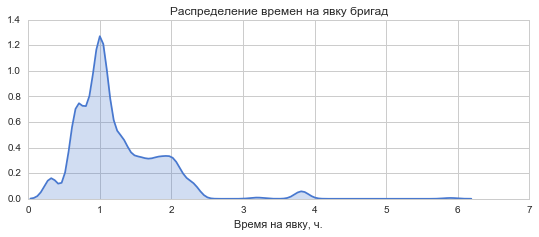

In [188]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'tt', 'state', 'loco', 'state_info']
team_plan['tt'] = team_plan.time_end - team_plan.time_start
min_presenting = team_plan[team_plan.state == 2][team_cols].tt.min()
max_presenting = team_plan[team_plan.state == 2][team_cols].tt.max()
add_header('Разброс времен на явку бригад: от %.2f ч. до %.2f ч.' % (min_presenting / 3600, max_presenting / 3600))

sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 3))
ax = sns.distplot(team_plan[team_plan.state == 2][team_cols].tt / 3600, hist=False, bins=20, color='b', kde_kws={'shade':True})
ax.set(xlabel='Время на явку, ч.', title='Распределение времен на явку бригад')
filename = 'team_presenting.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [189]:
team_plan['next_state'] = team_plan.state.shift(-1)
team_plan['next_time_start_f'] = team_plan.time_start_f.shift(-1)
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'next_state', 'time_start_f', 'time_end_f', 'next_time_start_f']
rest_pres = team_plan[(team_plan.team == team_plan.team.shift(-1)) 
                     & (team_plan.state == 4) & (team_plan.next_state == 2)
                     & (team_plan.time_end_f != team_plan.next_time_start_f)]
add_header('Всего %d бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):' 
      % rest_pres.team.drop_duplicates().count())
add_line(rest_pres[rest_pres.time_start >= current_time].sort_values('time_start').head(10)[cols])
add_header('\nРаспределение таких ошибочных явок после отдыха по станциям (показаны первые 5):')
add_line(rest_pres.st_from_name.value_counts().head())

Всего 1055 бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):
         team         st_from_name           st_to_name  state  next_state   time_start_f     time_end_f next_time_start_f
 200200227694                ТЫРМА                ТЫРМА      4           2  Jul 13, 10:00  Jul 13, 13:00     Jul 13, 17:04
 200200194088          СКОВОРОДИНО          СКОВОРОДИНО      4           2  Jul 13, 10:00  Jul 13, 15:41     Jul 13, 15:49
 210219039838             УЛАН-УДЭ             УЛАН-УДЭ      4           2  Jul 13, 10:00  Jul 13, 14:30     Jul 13, 15:13
 200200102632  КОРШУНИХА-АНГАРСКАЯ  КОРШУНИХА-АНГАРСКАЯ      4           2  Jul 13, 10:02  Jul 13, 16:02     Jul 15, 12:53
 200200185620         ХАБАРОВСК II         ХАБАРОВСК II      4           2  Jul 13, 10:02  Jul 13, 14:19     Jul 13, 15:25
 200200248044                УРУША                УРУША      4           2  Jul 13, 10:03  Jul 13, 14:29     Jul 13, 19:54
 200200223212            МАГДАГАЧИ 

<a id='check_useful_assign'></a>
## Проверка использования бригад [ToC](#toc)

In [190]:
add_header('Проверка использования бригад', h=2, p=False)

<a id='only_pass'></a>
### Бригады, запланированные к отправлению пассажирами без последующей подвязки [ToC](#toc)

In [191]:
add_header('Проверка использования бригад после засылки пассажирами', h=3, p=False)

In [192]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'depot_name',
        'state', 'all_states']

In [193]:
def get_cat(all_states):
    if 1 in all_states:
        return 'work'
    elif (len(all_states) == 1) & (all_states[0] == 2):
        return 'only_presence'
    elif len(all_states) == 2:
        if ((all_states[0] == 4) & (all_states[1] == 0)):
            return 'pass_home'
        else:
            return 'fail'
    else:
        return 'fail'

team_plan['cat'] = team_plan.all_states.apply(get_cat)
only_pass_teams = team_plan[(team_plan.cat == 'fail') & (team_plan.state_info != '2')]
                            
add_header('Всего %d бригад, для которых планируется отправка пассажиром и не планируется работа с поездом' 
      % only_pass_teams.team.drop_duplicates().count())

Всего 398 бригад, для которых планируется отправка пассажиром и не планируется работа с поездом


In [194]:
add_header('Станции, с которых чаще всегда планируется лишняя отправка пассажирами:')
add_line(only_pass_teams.drop_duplicates('team').st_from_name.value_counts().head(10))

Станции, с которых чаще всегда планируется лишняя отправка пассажирами:
ИЛАНСКАЯ                    91
КРАСНОЯРСК-ВОСТОЧНЫЙ        82
УЛАН-УДЭ                    42
ВЫСОКОГОРНАЯ                24
ЛЕНА                        19
ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ    16
КОРШУНИХА-АНГАРСКАЯ         15
ИРКУТСК-СОРТИРОВОЧНЫЙ       13
РУЖИНО                      12
СЕВЕРОБАЙКАЛЬСК              9


In [195]:
with pd.option_context('display.max_colwidth', 25):
    if only_pass_teams.team.drop_duplicates().count() != 0:
        add_header('Примеры:')
        for team in only_pass_teams.team.drop_duplicates().iloc[:3].values:    
            add_line(team_plan[team_plan.team == team][cols])
            add_line('')

Примеры:
         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200259703     УЛАН-УДЭ    МЫСОВАЯ  Jul 13, 10:16  Jul 13, 12:34   УЛАН-УДЭ      0     [0, 4]
 200200259703      МЫСОВАЯ    МЫСОВАЯ  Jul 13, 13:04  Jul 13, 19:46   УЛАН-УДЭ      4     [0, 4]
 200200259703      МЫСОВАЯ   УЛАН-УДЭ  Jul 13, 19:46  Jul 13, 21:48   УЛАН-УДЭ      0     [0, 4]

         team              st_from_name                st_to_name   time_start_f     time_end_f                depot_name  state all_states
 200200136324  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ                   ЖИРЕКЕН  Jul 14, 01:18  Jul 14, 02:13  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ      0     [0, 4]
 200200136324                   ЖИРЕКЕН                    ЗИЛОВО  Jul 14, 02:13  Jul 14, 03:02  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ      0     [0, 4]
 200200136324                    ЗИЛОВО               КСЕНЬЕВСКАЯ  Jul 14, 03:02  Jul 14, 05:24  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ      0     [0, 4]
 200200136324               КСЕНЬЕВСКАЯ   

In [196]:
irk = only_pass_teams[only_pass_teams.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ']
if not irk.empty:
    add_header('Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:')
    add_line(team_plan[team_plan.team == irk.iloc[0].team][cols])

Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:
         team         st_from_name           st_to_name   time_start_f     time_end_f           depot_name  state all_states
 210217155507  ИРКУТСК-СОРТИРОВ...            ГОНЧАРОВО  Jul 14, 02:44  Jul 14, 03:08  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507            ГОНЧАРОВО          БОЛЬШОЙ ЛУГ  Jul 14, 03:08  Jul 14, 03:54  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507          БОЛЬШОЙ ЛУГ        АНДРИАНОВСКАЯ  Jul 14, 03:54  Jul 14, 04:54  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507        АНДРИАНОВСКАЯ            АНГАСОЛКА  Jul 14, 04:54  Jul 14, 05:07  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507            АНГАСОЛКА          СЛЮДЯНКА II  Jul 14, 05:07  Jul 14, 05:33  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507          СЛЮДЯНКА II           СЛЮДЯНКА I  Jul 14, 05:33  Jul 14, 05:39  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 210217155507           СЛЮДЯНКА I           СЛЮДЯНКА

<a id='only_presence'></a>
### Бригады, планируемые только на явку [ToC](#toc)

In [197]:
add_header('Бригады, планируемые только на явку', h=3, p=False)

In [198]:
cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'depot_name', 'state_info', 'all_states']
only_pr = team_plan[team_plan.cat == 'only_presence']
if not only_pr.empty:
    add_header('Всего %d бригад, запланированных только на явку.' % only_pr.team.drop_duplicates().count())
    add_line('')
    add_header('Распределение по депо станции явки:')
    add_line(only_pr.drop_duplicates('team').st_from_name.value_counts().head())
    add_line('')
    add_header('Распределение по типу бригады:')
    add_line(only_pr.drop_duplicates('team').team_type.value_counts())
    add_line('')
    add_header('Примеры бригад:')
    add_line(only_pr[cols].head(10))
else:
    add_header('В плане нет бригад, запланированных только на явку')

Всего 570 бригад, запланированных только на явку.

Распределение по депо станции явки:
ИЛАНСКАЯ                76
ЛЕНА                    61
ВЫСОКОГОРНАЯ            61
КРАСНОЯРСК-ВОСТОЧНЫЙ    40
ВЕРХНЕЗЕЙСК             39

Распределение по типу бригады:
Фейковая    400
Реальная    170

Примеры бригад:
         team         st_from_name   time_start_f     time_end_f           depot_name state_info all_states
 200200224229  ЧЕРНЫШЕВСК-ЗАБАЙ...  Jul 13, 08:23  Jul 13, 09:15  ЧЕРНЫШЕВСК-ЗАБАЙ...          2        [2]
 200200189038          СМОЛЯНИНОВО  Jul 13, 05:00  Jul 13, 06:30               РУЖИНО          8        [2]
 200200242540            КАРЫМСКАЯ  Jul 13, 07:44  Jul 13, 09:50  ЧЕРНЫШЕВСК-ЗАБАЙ...          8        [2]
 220204252508               МОГОЧА  Jul 13, 09:30  Jul 13, 10:30               МОГОЧА          2        [2]
 200200206726            КАРЫМСКАЯ  Jul 13, 07:54  Jul 13, 10:00            КАРЫМСКАЯ          2        [2]
 200200163912            ФЕВРАЛЬСК  Jul 13, 04:31

## Проверка наличия явки в планах у всех запланированных бригад

In [199]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
no_pres = team_plan[team_plan.all_states.apply(lambda x: (2 not in x) & (1 in x))]
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
add_header('Всего событие явки не запланировано у %d бригад (%.2f%%). Примеры:'
           % (no_pres.drop_duplicates('team').team.count(),
              100 * no_pres.drop_duplicates('team').team.count() / team_plan.drop_duplicates('team').team.count()))
add_line(team_plan[team_plan.team == no_pres.iloc[0].team][cols])
add_line(team_plan[team_plan.team == no_pres.iloc[1].team][cols])
add_header('Распределение по типу бригад (в долях):')
add_line(no_pres.drop_duplicates('team').team_type.value_counts(normalize=True))

Всего событие явки не запланировано у 1265 бригад (22.52%). Примеры:
         team st_from_name           st_to_name   time_start_f     time_end_f  state          loco
 200200164066          УЯР               ЗЫКОВО  Jul 13, 09:14  Jul 13, 11:00      1  200200100465
 200200164066       ЗЫКОВО  КРАСНОЯРСК-ВОСТО...  Jul 13, 11:00  Jul 13, 11:10      1  200200100465
         team st_from_name           st_to_name   time_start_f     time_end_f  state          loco
 200200164066          УЯР               ЗЫКОВО  Jul 13, 09:14  Jul 13, 11:00      1  200200100465
 200200164066       ЗЫКОВО  КРАСНОЯРСК-ВОСТО...  Jul 13, 11:00  Jul 13, 11:10      1  200200100465
Распределение по типу бригад (в долях):
Реальная    0.628458
Фейковая    0.371542


<a id='pass_teams_in_plan'></a>
## Проверка подвязки негрузовых бригад [ToC](#toc)

In [200]:
add_header('Проверка подвязки негрузовых бригад', h=2, p=False)

In [201]:
cols = ['team', 'ttype', 'loco_info', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco']
bad_pass_teams = team_plan[(team_plan.ttype == 0) & (team_plan.loco != team_plan.loco_info) 
                           & (team_plan.state.isin([0, 1]))][cols]
if bad_pass_teams.empty:
    add_header('В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных')
else:
    add_header('Всего %d негрузовых бригад, для которых запланирована подвязка, отличная от подвязки во входных данных:' 
              % bad_pass_teams.drop_duplicates('team').team.count())
    add_line(bad_pass_teams.drop_duplicates('team')[cols].head())

В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных


[ToC](#toc)
## Проверка сохранения предыдущих времен явок

В планировщик в сообщениях `prev_team` передаются времена явок бригад, запланированные на предыдущем расчете. В зависимости от горизонта, на котором запланированы эти явки, их при новом расчете можно сдвигать лишь на очень ограниченное время.

In [202]:
add_header('Проверка сохранения предыдущих времен явок', h=2, p=False)

In [203]:
add_line('Время начала планирования: %s' % nice_time(current_time))
prev_team = pd.read_csv(FOLDER + 'prev_team.csv', dtype={'team':str})
prev_team['dt_time'] = prev_team.prev_ready_time.apply(nice_time)
prev_team['team_type'] = prev_team.team.apply(lambda x: int(str(x)[0]))
prev_team['plan_hor'] = (prev_team.prev_ready_time - current_time) / 3600
team_plan['prev_ready_time'] = team_plan.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_plan['prev_ready_time_f'] = team_plan.prev_ready_time.apply(nice_time)

prev_team_no_planned = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))
                                 & (prev_team.team.isin(team_plan[team_plan.state.isin([0, 1])].team) == False)]
prev_team_no_planned_6 = prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                              & (prev_team_no_planned.plan_hor < 6)]
prev_team_n = prev_team[(prev_team.team_type != 7) & (prev_team.team.isin(team_info.team))].team.count()
if prev_team_no_planned.empty:
    add_header('Все бригады с предыдущими явками запланированы')
else:
    add_header('Не запланировано %d бригад (%.2f%%) с предыдущими явками (%d на горизонте до 6 часов). Примеры:'
              % (prev_team_no_planned.team.count(),                  
                 100 * prev_team_no_planned.team.count() / prev_team_n,
                 prev_team_no_planned_6.team.count()))
    add_line(prev_team_no_planned[(prev_team_no_planned.plan_hor > 0) 
                                  & (prev_team_no_planned.plan_hor < 6)].sort_values('plan_hor').head(10))    

cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'state', 'prev_ready_time_f']
tp_first = team_plan[team_plan.team.isin(team_info[team_info.state == '3'].team)].drop_duplicates('team').copy()
#tp_first = team_plan.drop_duplicates('team').copy()

Время начала планирования: Jul 13, 10:00
Все бригады с предыдущими явками запланированы


In [204]:
def get_prev_ready_lag(prev_ready_time, current_time):
    if np.isnan(prev_ready_time): prev_ready_time = 0        
    d = prev_ready_time - current_time
    if d < 1 * 3600:
        lag = 0
    elif d < 3 * 3600:
        lag = 0.25 * 3600
    elif d < 6 * 3600:
        lag = 0.5 * 3600
    else:
        lag = 1 * 3600
    return lag

tp_first['good_lag'] = tp_first.apply(lambda x: get_prev_ready_lag(x.prev_ready_time, current_time), axis=1)
cols = ['team', 'st_from_name', 'time_start_f', 'state', 'prev_ready_time_f', 'good_lag', 'real_lag', 'state_info']
tp_first['real_lag'] = tp_first.time_start - tp_first.prev_ready_time
good_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2)
                     & (tp_first.good_lag >= np.abs(tp_first.real_lag))]

bad_prev = tp_first[(tp_first.team.isin(prev_team.team)) & (tp_first.state == 2)
                     & (tp_first.good_lag < np.abs(tp_first.real_lag))]
if bad_prev.empty:
    add_header('Все запланированные бригады с предыдущими явками запланированы на явку без неприемлемых задержек')
else:
    add_header('Всего %d бригад с предыдущими явками (%.2f%% от запланированных) с существенными отклонениями времен явок:'
              % (bad_prev.team.count(), 
                 100 * bad_prev.team.count() / (prev_team.team.count() - prev_team_no_planned.team.count())))
    add_line(bad_prev[cols].head(10))

Все запланированные бригады с предыдущими явками запланированы на явку без неприемлемых задержек


In [205]:
print(nice_time(current_time))
team_info['depot_name'] = team_info.depot.map(st_names.name)
team_info['prev_ready_time'] = team_info.team.map(prev_team.drop_duplicates('team').set_index('team').prev_ready_time)
team_info['prev_ready_time_f'] = team_info.prev_ready_time.apply(nice_time)
team_info['oper_time_f'] = team_info.oper_time.apply(nice_time)
team_info['plan_start_time'] = team_info.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                  .drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)
cols = ['team', 'number', 'oper_time_f', 'depot_time_f', 'state', 'prev_ready_time_f', 'plan_start_time_f']
team_info[(team_info.uth == 1) & (team_info.state == '3')
          & (team_info.depot_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ')].sort_values('oper_time')[cols]

Jul 13, 10:00


,team,number,oper_time_f,depot_time_f,state,prev_ready_time_f,plan_start_time_f


[ToC](#toc)
## Проверка возврата правильных времен явок у бригад

Чтобы на форме текущего планирования можно было рассчитать рабочее время бригады, из планировщика в плане должны быть возвращены времена явок всех бригад:
* Для бригад, у которых начальное состояние было отличное от 3 или 4, возвращенное время явки должно копировать время явки, переданное во входных данных.
* Для бригад в начальном состоянии 3 или 4 и фейковых бригад время явки должно вычисляться на основе запланированного времени отправления.

In [206]:
add_header('Проверка возврата правильных времен явок у бригад', h=2, p=False)

Всего 674 бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200164081  1468513007  Jul 14, 19:16          1  1468392600  Jul 13, 09:50
 200200224229  1468387404  Jul 13, 08:23          2  1468390500  Jul 13, 09:15
 200200233912  1468407948  Jul 13, 14:05          2  1468390200  Jul 13, 09:10
 200200136435  1468452443  Jul 14, 02:27          1  1468380000  Jul 13, 06:20
 200200164013  1468414201  Jul 13, 15:50          1  1468368000  Jul 13, 03:00
 200200224145  1468438680  Jul 13, 22:38          5  1468360800  Jul 13, 01:00
 200200198917  1468583655  Jul 15, 14:54          1  1468385100  Jul 13, 07:45
 220204252508  1468391419  Jul 13, 09:30          2  1468395000  Jul 13, 10:30
 200200224187  1468411500  Jul 13, 15:05          1  1468368000  Jul 13, 03:00
 200200206726  1468385641  Jul 13, 07:54          2  1468393200  Jul 13, 10:00

Распределение по состояниям:
1    407

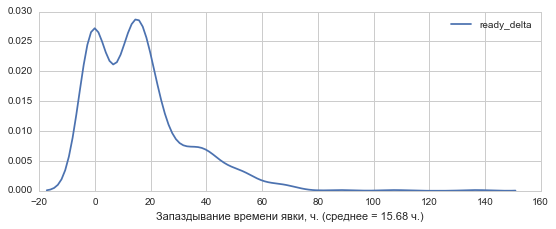

In [207]:
real_pres = team_info[team_info.state.isin(['1', '2', '5'])][['team', 'presence', 'presence_norm']]
a = team_plan[(team_plan.state == 2) & (team_plan.team.isin(real_pres.team))].drop_duplicates('team')
real_pres_fail = a[a.time_start != a.presence][['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']]
if real_pres_fail.empty:
    add_header('Для всех бригад в состояниях 1, 2, 5 явки запланированы верно')
else:
    add_header('Всего %d бригад в состояниях 1, 2, 5, для которых возвращена неверная первая явка. Примеры:' 
               % real_pres_fail.team.count())
    add_line(real_pres_fail.head(10))
    add_line('\nРаспределение по состояниям:')
    add_line(real_pres_fail.state_info.value_counts())
    team_id = real_pres_fail.iloc[0].team
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    add_line(team_plan[team_plan.team == team_id][cols])
    real_pres_fail['ready_delta'] = real_pres_fail.time_start - real_pres_fail.presence
    fig = plt.figure(figsize=(8, 3))    
    #fig = plt.figure()
    sns.set(style='whitegrid', context='notebook')
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team125_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

Для бригад в начальных состояниях 6 (прибыла на станцию с локомотивом), 7 (прибыла на станцию пассажиром), 9 (сдача локомотива) проверяем, запланирован ли далее для бригады отдых. Если отдых запланирован, то не сравниваем время явки с исходным - оно будет задано вновь после отдыха. Если отдых не запланирован, то явка должна быть возвращена.

Для 71 бригад в исходных состояниях 6, 7, 9 не запланированы явки. Примеры:
         team            loc_name state_info all_states
 200200259802            МАРИИНСК          9        [1]
 200200259932            ЗАГУСТАЙ          6        [1]
 200200223794        ВЫСОКОГОРНАЯ          6        [1]
 200200105268  АРТЕМ-ПРИМОРСКИЙ I          6        [1]
 200200225768               ТАГУЛ          6        [1]

Распределение по состояниям:
6    59
9    12
         team st_from_name st_to_name   time_start_f     time_end_f  state          loco
 200200259802     МАРИИНСК    БОГОТОЛ  Jul 13, 12:41  Jul 13, 14:57      1  200200092498
 200200259802      БОГОТОЛ    ЗЕРЦАЛЫ  Jul 13, 14:57  Jul 13, 15:47      1  200200092498
 200200259802      ЗЕРЦАЛЫ   АЧИНСК I  Jul 13, 15:47  Jul 13, 16:03      1  200200092498

Всего 4 бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:
         team  time_start   time_start_f state_info    presence  presence_norm
 200200250438  

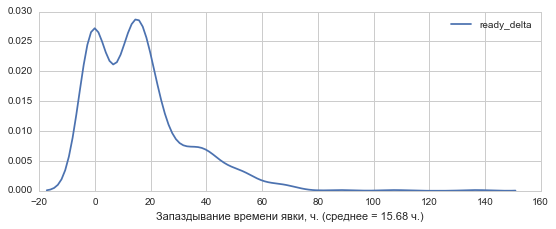

In [208]:
real_pres = team_info[team_info.state.isin(['6', '7', '9'])]
tp = team_plan[(team_plan.team.isin(real_pres.team)) & (team_plan.all_states.apply(lambda x: 4 not in x))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 6, 7, 9 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    
tp_ready_time_fail = tp[(tp.state == 2) & (tp.time_start != tp.presence)].drop_duplicates('team')
if tp_ready_time_fail.empty:
    add_header('Для всех бригад в состояниях 6, 7, 9 явки запланированы верно')
else:
    add_header('\nВсего %d бригад в состояниях 6, 7, 9, для которых возвращена неверная первая явка. Примеры:' 
               % tp_ready_time_fail.team.count())
    cols = ['team', 'time_start', 'time_start_f', 'state_info', 'presence', 'presence_norm']
    add_line(tp_ready_time_fail[cols].head())
    add_line('\nРаспределение по состояниям:')
    add_line(tp_ready_time_fail.state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_ready_time_fail.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])
    fig = plt.figure(figsize=(8, 3))            
    sns.kdeplot(real_pres_fail.ready_delta / 3600)
    plt.xlabel('Запаздывание времени явки, ч. (среднее = %.2f ч.)' % np.mean(real_pres_fail.ready_delta / 3600))
    filename = 'team679_ready_late.png'
    fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
    add_image(filename)

In [209]:
tp = team_plan[(team_plan.state_info.isin(['3', '4'])) & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех бригад в состояниях 3, 4 запланированы требуемые явки')
else:
    add_header('Для %d бригад в исходных состояниях 3, 4 не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())    
    add_line('\nРаспределение по состояниям:')
    add_line(tp_no_ready.drop_duplicates('team').state_info.value_counts())
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для всех бригад в состояниях 3, 4 запланированы требуемые явки


In [210]:
tp = team_plan[(team_plan.team_type == 'Фейковая') & (team_plan.all_states.apply(lambda x: (x[0] != 0) & (1 in x)))]
tp_no_ready = tp[tp.all_states.apply(lambda x: 2 not in x)]
if tp_no_ready.empty:
    add_header('Для всех фейковых бригад запланированы требуемые явки')
else:
    add_header('Для %d фейковых бригад не запланированы явки. Примеры:' 
               % tp_no_ready.drop_duplicates('team').team.count())
    add_line(tp_no_ready.drop_duplicates('team')[['team', 'loc_name', 'state_info', 'all_states']].head())        
    cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
    team_id = tp_no_ready.iloc[0].team
    add_line(team_plan[team_plan.team == team_id][cols])

Для 470 фейковых бригад не запланированы явки. Примеры:
         team loc_name state_info all_states
 777700001923      NaN        NaN        [1]
 777700001921      NaN        NaN        [1]
 777700001920      NaN        NaN        [1]
 777700001927      NaN        NaN        [1]
 777700001928      NaN        NaN        [1]
         team st_from_name st_to_name   time_start_f     time_end_f  state          loco
 777700001923  ВЕРХНЕЗЕЙСК     ДИПКУН  Jul 14, 21:50  Jul 15, 01:51      1  200200099703
 777700001923       ДИПКУН  БЕСТУЖЕВО  Jul 15, 01:51  Jul 15, 05:41      1  200200099703
 777700001923    БЕСТУЖЕВО    ШАХТАУМ  Jul 15, 05:41  Jul 15, 05:58      1  200200099703
 777700001923      ШАХТАУМ      ТЫНДА  Jul 15, 05:58  Jul 15, 06:19      1  200200099703


[ToC](#toc)
## Проверка планирования УТХ бригад

Если для какого-то депо приписки переданы бригады с признаком `uth(1)`, то такие бригады должны планироваться в первую очередь, и только после них должны планироваться бригады с признаком `uth(0)`. Для бригад с признаком `uth(0)` должен производиться сдвиг явки на время после максимального времени явки бригад с `uth(1)` для данного депо. Если бригад с `uth(1)` для данного депо не передано, то сдвиг производить не требуется.

In [211]:
add_header('Проверка планирования УТХ-бригад', h=2, p=False)

### УТХ-бригады должны планироваться раньше не-УТХ бригад, начальное состояние которых = 3

In [212]:
print(nice_time(current_time))
uth_depots = team_info[team_info.uth == 1].depot.unique()
cols = ['team', 'depot_name', 'uth', 'time_start_f', 'state']

t_ready_max = team_info[(team_info.uth == 1)].groupby('depot').presence.max()
t_plan_max = team_plan[(team_plan.uth == 1) 
                       & (team_plan.state.isin([0, 1]))].drop_duplicates('team').groupby('depot').time_start.max()
team_plan['uth_plan_max_time'] = team_plan.depot.map(t_plan_max)
team_plan['uth_plan_max_time_f'] = team_plan.uth_plan_max_time.apply(nice_time)
team_plan['uth_ready_max_time'] = team_plan.depot.map(t_ready_max)
team_plan['uth_ready_max_time_f'] = team_plan.uth_ready_max_time.apply(nice_time)
cols = ['team', 'depot_name', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 
        'uth_plan_max_time_f', 'uth_ready_max_time_f']
t_uth_soft_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_plan_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')
t_uth_hard_fail = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') & (team_plan.depot.isin(uth_depots))
                      & (team_plan.state.isin([0, 1])) & (team_plan.time_start < team_plan.uth_ready_max_time)
                      & (team_plan.depot_name == team_plan.loc_name)].drop_duplicates('team')

total_uth_depots = team_plan[(team_plan.uth == 0) & (team_plan.state_info == '3') 
                             & (team_plan.depot.isin(uth_depots))].team.drop_duplicates().count()

t_uth_fail_diff_depot_n = t_uth_soft_fail[t_uth_soft_fail.depot_name != t_uth_soft_fail.st_from_name].team.count()

if t_uth_soft_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней УТХ-бригады' 
               % (t_uth_soft_fail.team.count(), 100 * t_uth_soft_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_soft_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_soft_fail[t_uth_soft_fail.depot_name == t_uth_soft_fail.st_from_name].head(10)[cols])    

Jul 13, 10:00
Нет случаев, когда не-УТХ-бригада планируется раньше УТХ-бригады


In [213]:
if t_uth_hard_fail.empty:
    add_header('Нет случаев, когда не-УТХ-бригада планируется раньше явки УТХ-бригады')
else:
    add_header('Всего %d не-УТХ-бригад (%.2f%%), которые отправлены ранее самой поздней явки УТХ-бригады' 
               % (t_uth_hard_fail.team.count(), 100 * t_uth_hard_fail.team.count() / total_uth_depots))
    add_header('-- из них %d бригад, у которых место явки не совпадает с депо приписки' % t_uth_fail_diff_depot_n)
    add_line('\nРаспределение по депо (первые 5):')
    add_line(t_uth_hard_fail.depot_name.value_counts().head(10))
    add_line('\nПримеры бригад (первые 10 по времени отправления):')
    add_line(t_uth_hard_fail[t_uth_hard_fail.depot_name == t_uth_hard_fail.st_from_name].head(10)[cols])    

Нет случаев, когда не-УТХ-бригада планируется раньше явки УТХ-бригады


### Проверка УТХ-бригад по одной станции

In [214]:
#st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
st_name = 'СЛЮДЯНКА I'

In [215]:
add_header('Проверка УТХ-бригад по депо %s' % st_name, h=2, p=False)

In [216]:
team_info['depot_name'] = team_info.depot.map(st_names.name)

#team_info.columns
team_info['plan_start_time'] = team_info.team\
                        .map(team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').set_index('team').time_start)
team_info['plan_start_time_f'] = team_info['plan_start_time'].apply(nice_time)

In [217]:
irk_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 1)]
add_header('Все УТХ-бригады из депо %s (%d):' % (st_name, irk_uth.team.count()))
cols = ['team', 'depot_name', 'uth', 'state', 'is_assign', 'presence_norm', 'plan_start_time_f']
pd.set_option('display.max_colwidth', 50)
add_line(irk_uth.sort_values('presence')[cols])
t_max = irk_uth.presence.max()
t_plan_max = irk_uth.plan_start_time.max()
add_line('Максимальное время явки УТХ-бригад депо %s: %s' % (st_name, nice_time(t_max)))
add_line('Максимальное время отправления УТХ-бригад депо %s: %s' % (st_name, nice_time(t_plan_max)))

Все УТХ-бригады из депо СЛЮДЯНКА I (0):
Empty DataFrame
Columns: [team, depot_name, uth, state, is_assign, presence_norm, plan_start_time_f]
Index: []
Максимальное время явки УТХ-бригад депо СЛЮДЯНКА I: 
Максимальное время отправления УТХ-бригад депо СЛЮДЯНКА I: 


In [218]:
cols = ['team', 'depot_name', 'depot_st_name', 'uth', 'state', 'loc_name', 'is_assign', 'presence_norm', 'plan_start_time_f']
irk_no_uth = team_info[(team_info.depot_name == st_name) & (team_info.uth == 0) & (team_info.state == '3')]
irk_no_uth.loc_name.value_counts()

СЛЮДЯНКА I    70
МЫСОВАЯ        1
Name: loc_name, dtype: int64

In [219]:
print(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_max)
print(irk_no_uth[irk_no_uth.loc_name == irk_no_uth.depot_name].plan_start_time.min() > t_plan_max)

False
False


In [220]:
irk_no_uth[irk_no_uth.loc_name != irk_no_uth.depot_name][cols]

,team,depot_name,depot_st_name,uth,state,loc_name,is_assign,presence_norm,plan_start_time_f
4575,200200173924,СЛЮДЯНКА I,МЫСОВАЯ,0,3,МЫСОВАЯ,True,"Jul 13, 12:30","Jul 13, 16:45"


In [221]:
cols = ['team', 'st_from_name', 'loc_name', 'state', 'presence_norm', 'time_start_f', 'uth', 'delta']
team_plan['delta'] = team_plan.time_start - team_plan.presence
add_header('Все запланированные бригады, отправленные со станции %s из начального state = 3' % st_name)
tp = team_plan[(team_plan.depot_name == st_name) 
          & (team_plan.state_info == '3') 
          & (team_plan.state.isin([0, 1]))
          & (team_plan.loc_name == st_name)]
add_line(tp.drop_duplicates('team').sort_values('time_start')[cols])

Все запланированные бригады, отправленные со станции СЛЮДЯНКА I из начального state = 3
         team st_from_name    loc_name  state  presence_norm   time_start_f  uth   delta
 200200117756   СЛЮДЯНКА I  СЛЮДЯНКА I      1  Jul 12, 20:46  Jul 13, 10:50    0   50628
 210212673273   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 12, 23:01  Jul 13, 11:09    0   43668
 210207676317   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 13, 06:41  Jul 13, 11:09    0   16080
 200200256661   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 13, 09:48  Jul 13, 11:09    0    4860
 200200257139   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 12, 22:49  Jul 13, 11:09    0   44388
 200200273236   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 12, 21:52  Jul 13, 11:09    0   47772
 210216938966   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 13, 02:04  Jul 13, 11:09    0   32688
 200200274815   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 12, 21:07  Jul 13, 11:09    0   50508
 200200277859   СЛЮДЯНКА I  СЛЮДЯНКА I      0  Jul 13, 00:15  Jul 13, 11:09    0   39240
 200200105897   СЛЮДЯН

In [222]:
(tp[tp.uth == 1].drop_duplicates('team').delta / 3600).describe()

count     0
mean    NaN
std     NaN
min     NaN
25%     NaN
50%     NaN
75%     NaN
max     NaN
Name: delta, dtype: float64

### Для бригад из депо, по которым нет УТХ-бригад, не должно быть большого сдвига времени явки

In [223]:
team_plan['depot_time_f'] = team_plan.depot_time.apply(nice_time)
ts = team_plan[(team_plan.uth == 0) & (team_plan.depot.isin(uth_depots) == False) & (team_plan.state_info == '3')].copy()
ts['delta'] = ts.time_start - ts.depot_time
cols = ['team', 'st_from_name', 'loc_name', 'depot_name', 'time_start_f', 'depot_time_f', 'delta']
ts.drop_duplicates('team')[cols]
delta75 = (ts.drop_duplicates('team').delta / 3600).describe()['75%']
if delta75 < 5:
    add_header('У 75% бригад из депо, по которым нет УТХ-бригад, разница между переданным и запланированным временем явки'
              + ' составляет меньше %.2f ч. (это ОК)' % delta75)
else:
    add_header('WARNING: разница между планируемым и переданным временем явки у бригад из депо, по которым нет УТХ-бригад' +
              'выглядит завышенной')
    ts[ts.delta > 5].sort_values('delta', ascending=False).head(10)[cols]

### План проверок порядка отправления бригад

1. Взять станцию (Слюдянка - с ней проще, поскольку, вроде бы, нет бригад депо Слюдянка, которые находятся на других станциях), собрать все бригады, которые на начало планирования находились на этой станции.
2. Собрать все бригады, у которых запланирован отдых на этой станции. Рассчитать время выхода с отдыха (можно грубо: +3 часа от времени прибытия).
3. Выстроить эти бригады в порядке готовности к отправлению из Слюдянки. Нужные параметры: депо приписки, участки обкатки, время готовности.
4. Составить список поездов (и их локомотивов), которые проходят через Слюдянку и у которых запланирована смена бригады в Слюдянке. Выстроить эти поезда по времени прибытия в Слюдянку.
5. Сличить два списка. Найти случаи, когда бригады привязываются "вразнобой". Исследовать значения функций полезности. Найти распределение времен ожидания бригад, стоянок и пр.

In [235]:
uth = list(pd.read_csv('./input/a.csv', header=None)[0].values)
uth = [str(x) for x in uth]
add_line(team_info[(team_info.team.isin(uth)) & (team_info.state == '3')
         & (team_info.loc_name != team_info.depot_name)][['team', 'depot_name', 'loc_name', 'state']])

         team    depot_name          loc_name state
 200200102355        МОГОЧА       КСЕНЬЕВСКАЯ     3
 200200164247      УЛАН-УДЭ  ПЕТРОВСКИЙ ЗАВОД     3
 200200109226   СМОЛЯНИНОВО        НОВОНЕЖИНО     3
 200200108090   СМОЛЯНИНОВО   КРАСНОАРМЕЙСКИЙ     3
 200200148587  ХАБАРОВСК II       ХАБАРОВСК I     3
 200200143858   СМОЛЯНИНОВО           ШКОТОВО     3
 200200192330        ЧИТА I            КАДАЛА     3
 200200171477   СМОЛЯНИНОВО        НОВОНЕЖИНО     3


## Экспорт в HTML [ToC](#toc)

In [225]:
filename = REPORT_FOLDER + 'team_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/team_report_20160805_190444.html
